<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/CNN_LSTM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리

https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch3-preprocessing.html

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KDT_project/ARIMA/ARIMA_data.csv').drop(['Unnamed: 0'],axis=1)
data = df.set_index(keys='ds',drop=True)
data

,y
ds,
20230221000030,1
20230221000100,1
20230221000130,1
20230221000200,1
20230221000230,1
...,...
20230503074200,0
20230503074230,0
20230503074300,0


In [ ]:
62176 / 928

67.0

## 총 67일간의 수면기록.
## 928번 * 30초 -> 7시간 44분 동안의 수면 기록

In [ ]:
import numpy as np

def create_sequences(data, seq_length):

  xs = []
  ys = []
  for i in range(67):
    data = data.iloc[i*928:(i+1)*928]
    for j in range(len(data)-seq_length):
      x = data.iloc[j:(j+seq_length)]
      y = data.iloc[j+seq_length]
      xs.append(x)
      ys.append(y)
  return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(data, seq_length)   # 일별로(길이:928)시점 중간중간 값을 test로 저장.

In [ ]:
print(X.shape, y.shape)   # 총 923개의 지도학습용 데이터가 구축됨.

(923, 5, 1) (923, 1)


In [ ]:
train_size = int(923 * 0.8)
print(train_size)

738


In [ ]:
(923 - 738) / 2   # train:val:test = 8:1:1 = 약 738 : 92 : 93

92.5

In [ ]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+92], y[train_size:train_size+92]
X_test, y_test = X[train_size+92:], y[train_size+92:]

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(738, 5, 1) (92, 5, 1) (93, 5, 1)
(738, 1) (92, 1) (93, 1)


In [ ]:
import torch

def make_Tensor(array):
    return torch.from_numpy(array).float()

In [ ]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

# CNN-LSTM

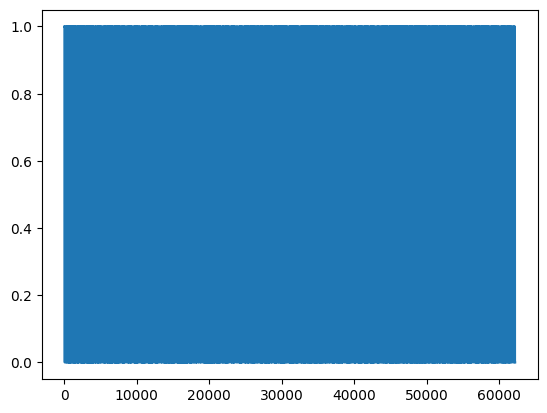

In [ ]:
plt.plot(data.values)

# 모델 생성


## sigmoid

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class SleepPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers):
    super(SleepPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
    self.sig=nn.Sigmoid()
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=n_layers
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
    )
  def forward(self, sequences):
    sequences = self.c1(sequences.view(len(sequences), 1, -1))
    # sequences = self.sig(sequences)
    lstm_out, self.hidden = self.lstm(
        sequences.view(len(sequences), self.seq_len-1, -1),
        self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    y_pred = self.sig(y_pred)
    return y_pred

# 모델 학습

In [ ]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
  loss_fn = torch.nn.BCELoss() #
  optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
  train_hist = []
  val_hist = []

  criterion = loss_fn
  for t in range(num_epochs):

    epoch_loss = 0

    for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함

      model.reset_hidden_state()

      # train loss
      seq = torch.unsqueeze(seq, 0)
      y_pred = model(seq)
      loss = criterion(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

      # update weights
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      epoch_loss += loss.item()

    train_hist.append(epoch_loss / len(train_data))

    if val_data is not None:

      with torch.no_grad():

        val_loss = 0

        for val_idx, val_seq in enumerate(val_data):

          model.reset_hidden_state() #seq 별로 hidden state 초기화

          val_seq = torch.unsqueeze(val_seq, 0)
          y_val_pred = model(val_seq)
          val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

          val_loss += val_step_loss

      val_hist.append(val_loss / len(val_data)) # val hist에 추가

      ## verbose 번째 마다 loss 출력
      if t % verbose == 0:
        print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

      ## patience 번째 마다 early stopping 여부 확인
      if (t % patience == 0) & (t != 0):

        ## loss가 커졌다면 early stop
        if val_hist[t - patience] < val_hist[t] :

          print('\n Early Stopping')

          break

    elif t % verbose == 0:
        print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


  return model, train_hist, val_hist

In [ ]:
model = SleepPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [ ]:
print(model)

SleepPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (sig): Sigmoid()
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.5572123187909604 val loss: 0.39581626653671265
Epoch 10 train loss: 0.12362242460271046 val loss: 0.2120039314031601
Epoch 20 train loss: 0.1228932238254585 val loss: 0.21613529324531555
Epoch 30 train loss: 0.12270016129302784 val loss: 0.21786679327487946
Epoch 40 train loss: 0.12260362110920957 val loss: 0.2189479023218155
Epoch 50 train loss: 0.12254068143362921 val loss: 0.21973228454589844
Epoch 60 train loss: 0.1224933070165981 val loss: 0.2203560769557953
Epoch 70 train loss: 0.122454635941532 val loss: 0.22088107466697693
Epoch 80 train loss: 0.12242141388341542 val loss: 0.2213403880596161
Epoch 90 train loss: 0.12239197050385318 val loss: 0.22175316512584686


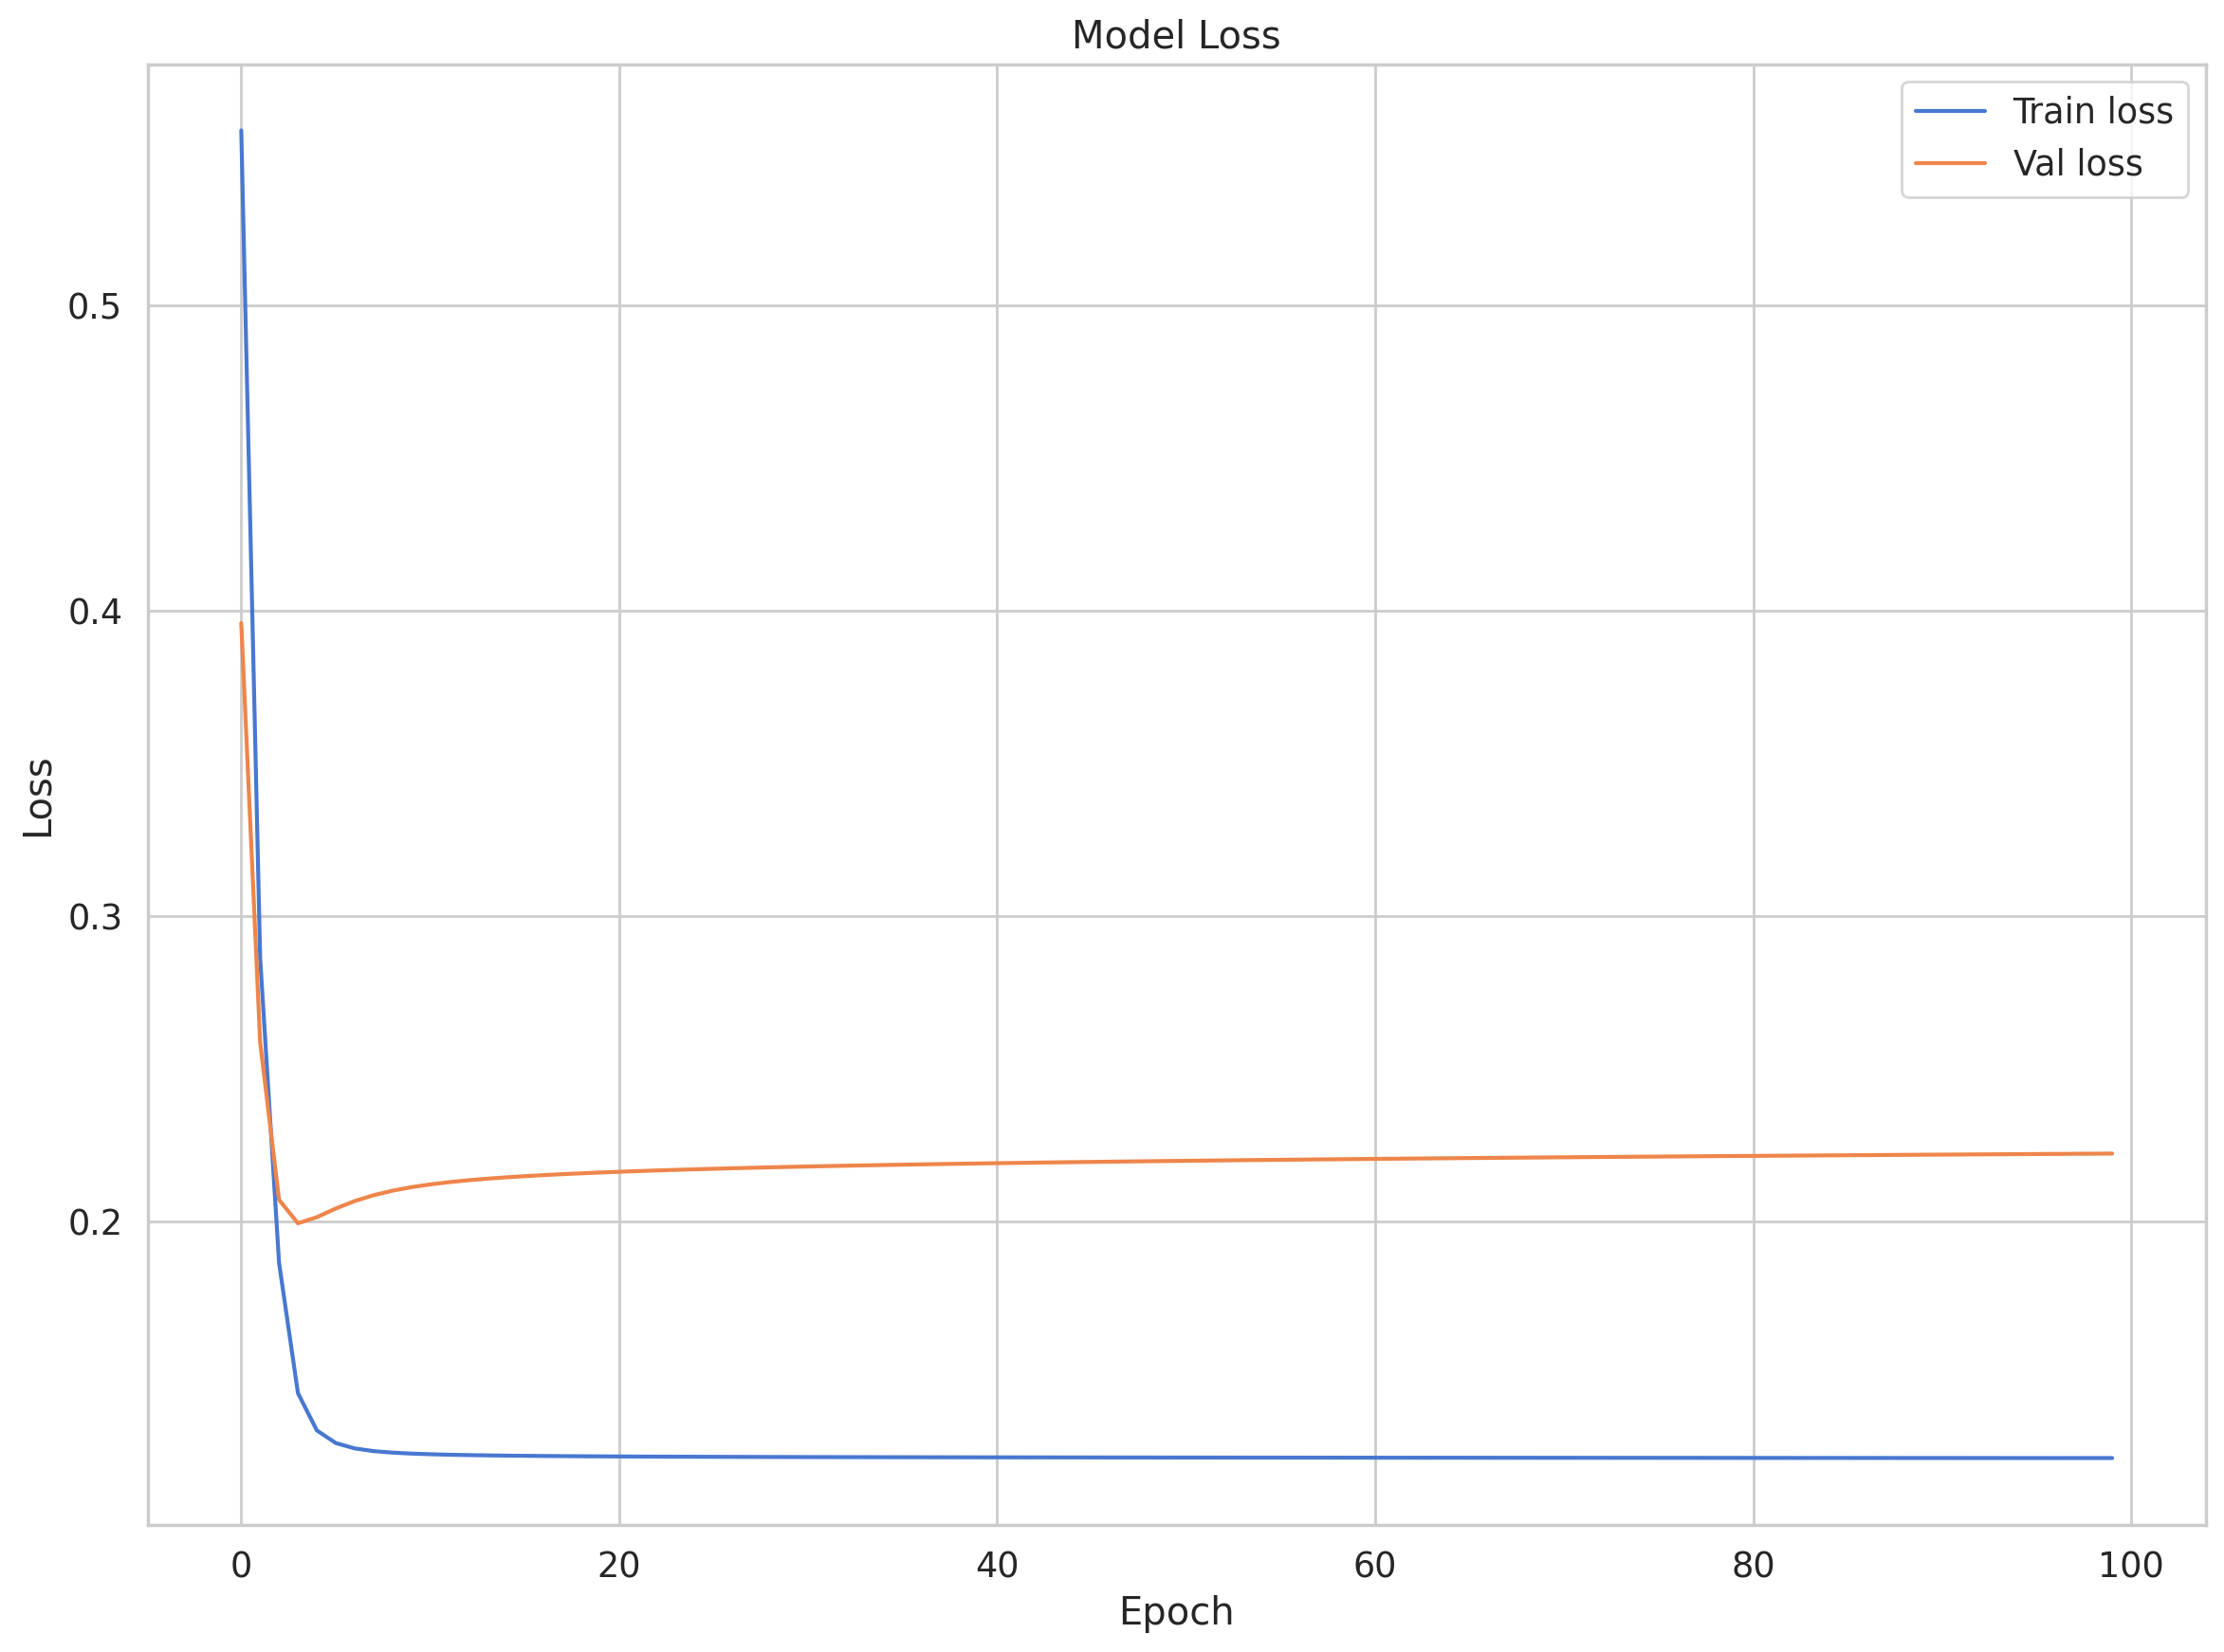

In [ ]:
plt.plot(train_hist, label="Train loss")
plt.plot(val_hist, label="Val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# 예측

In [ ]:
pred_dataset = X_test

with torch.no_grad():
  preds = []
  for _ in range(len(pred_dataset)):
    model.reset_hidden_state()
    y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)

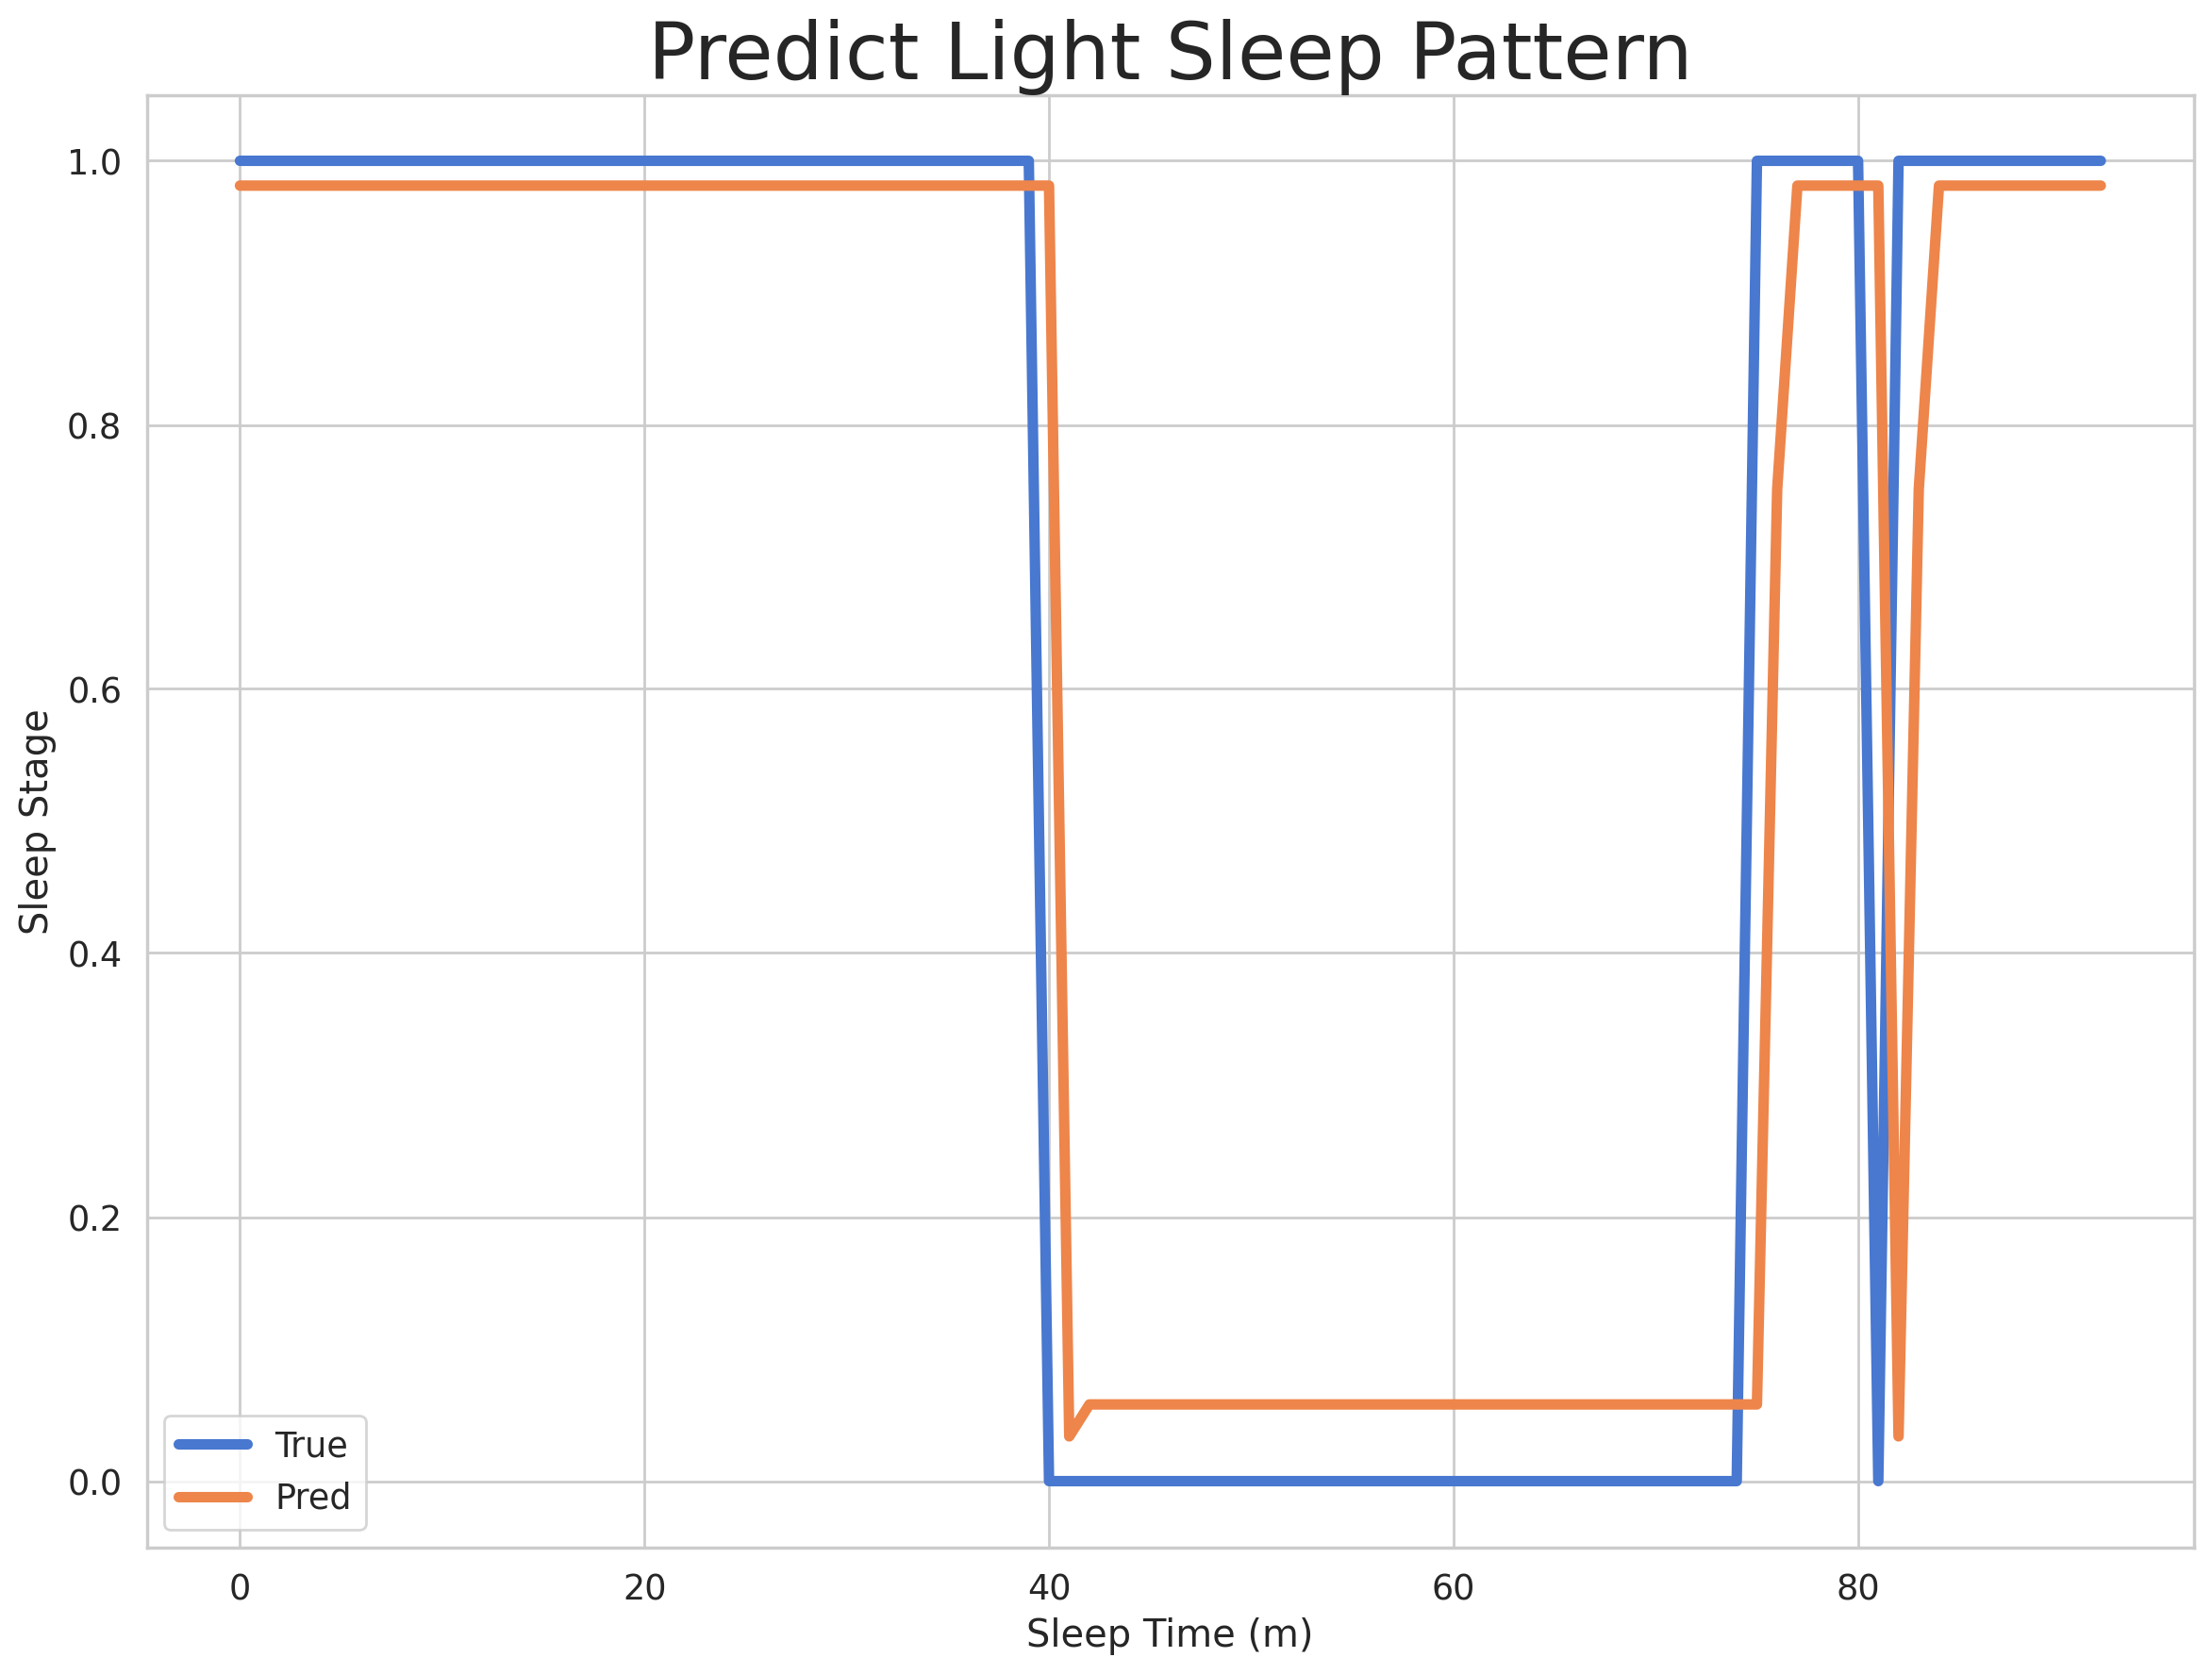

In [ ]:
plt.plot(np.array(y_test), label = 'True', linewidth=4)
plt.plot(np.array(preds), label = 'Pred', linewidth=4)
plt.xlabel('Sleep Time (m)')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중간
plt.ylabel('Sleep Stage')
plt.title('Predict Light Sleep Pattern', fontsize=30)
plt.legend()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  func(*ar

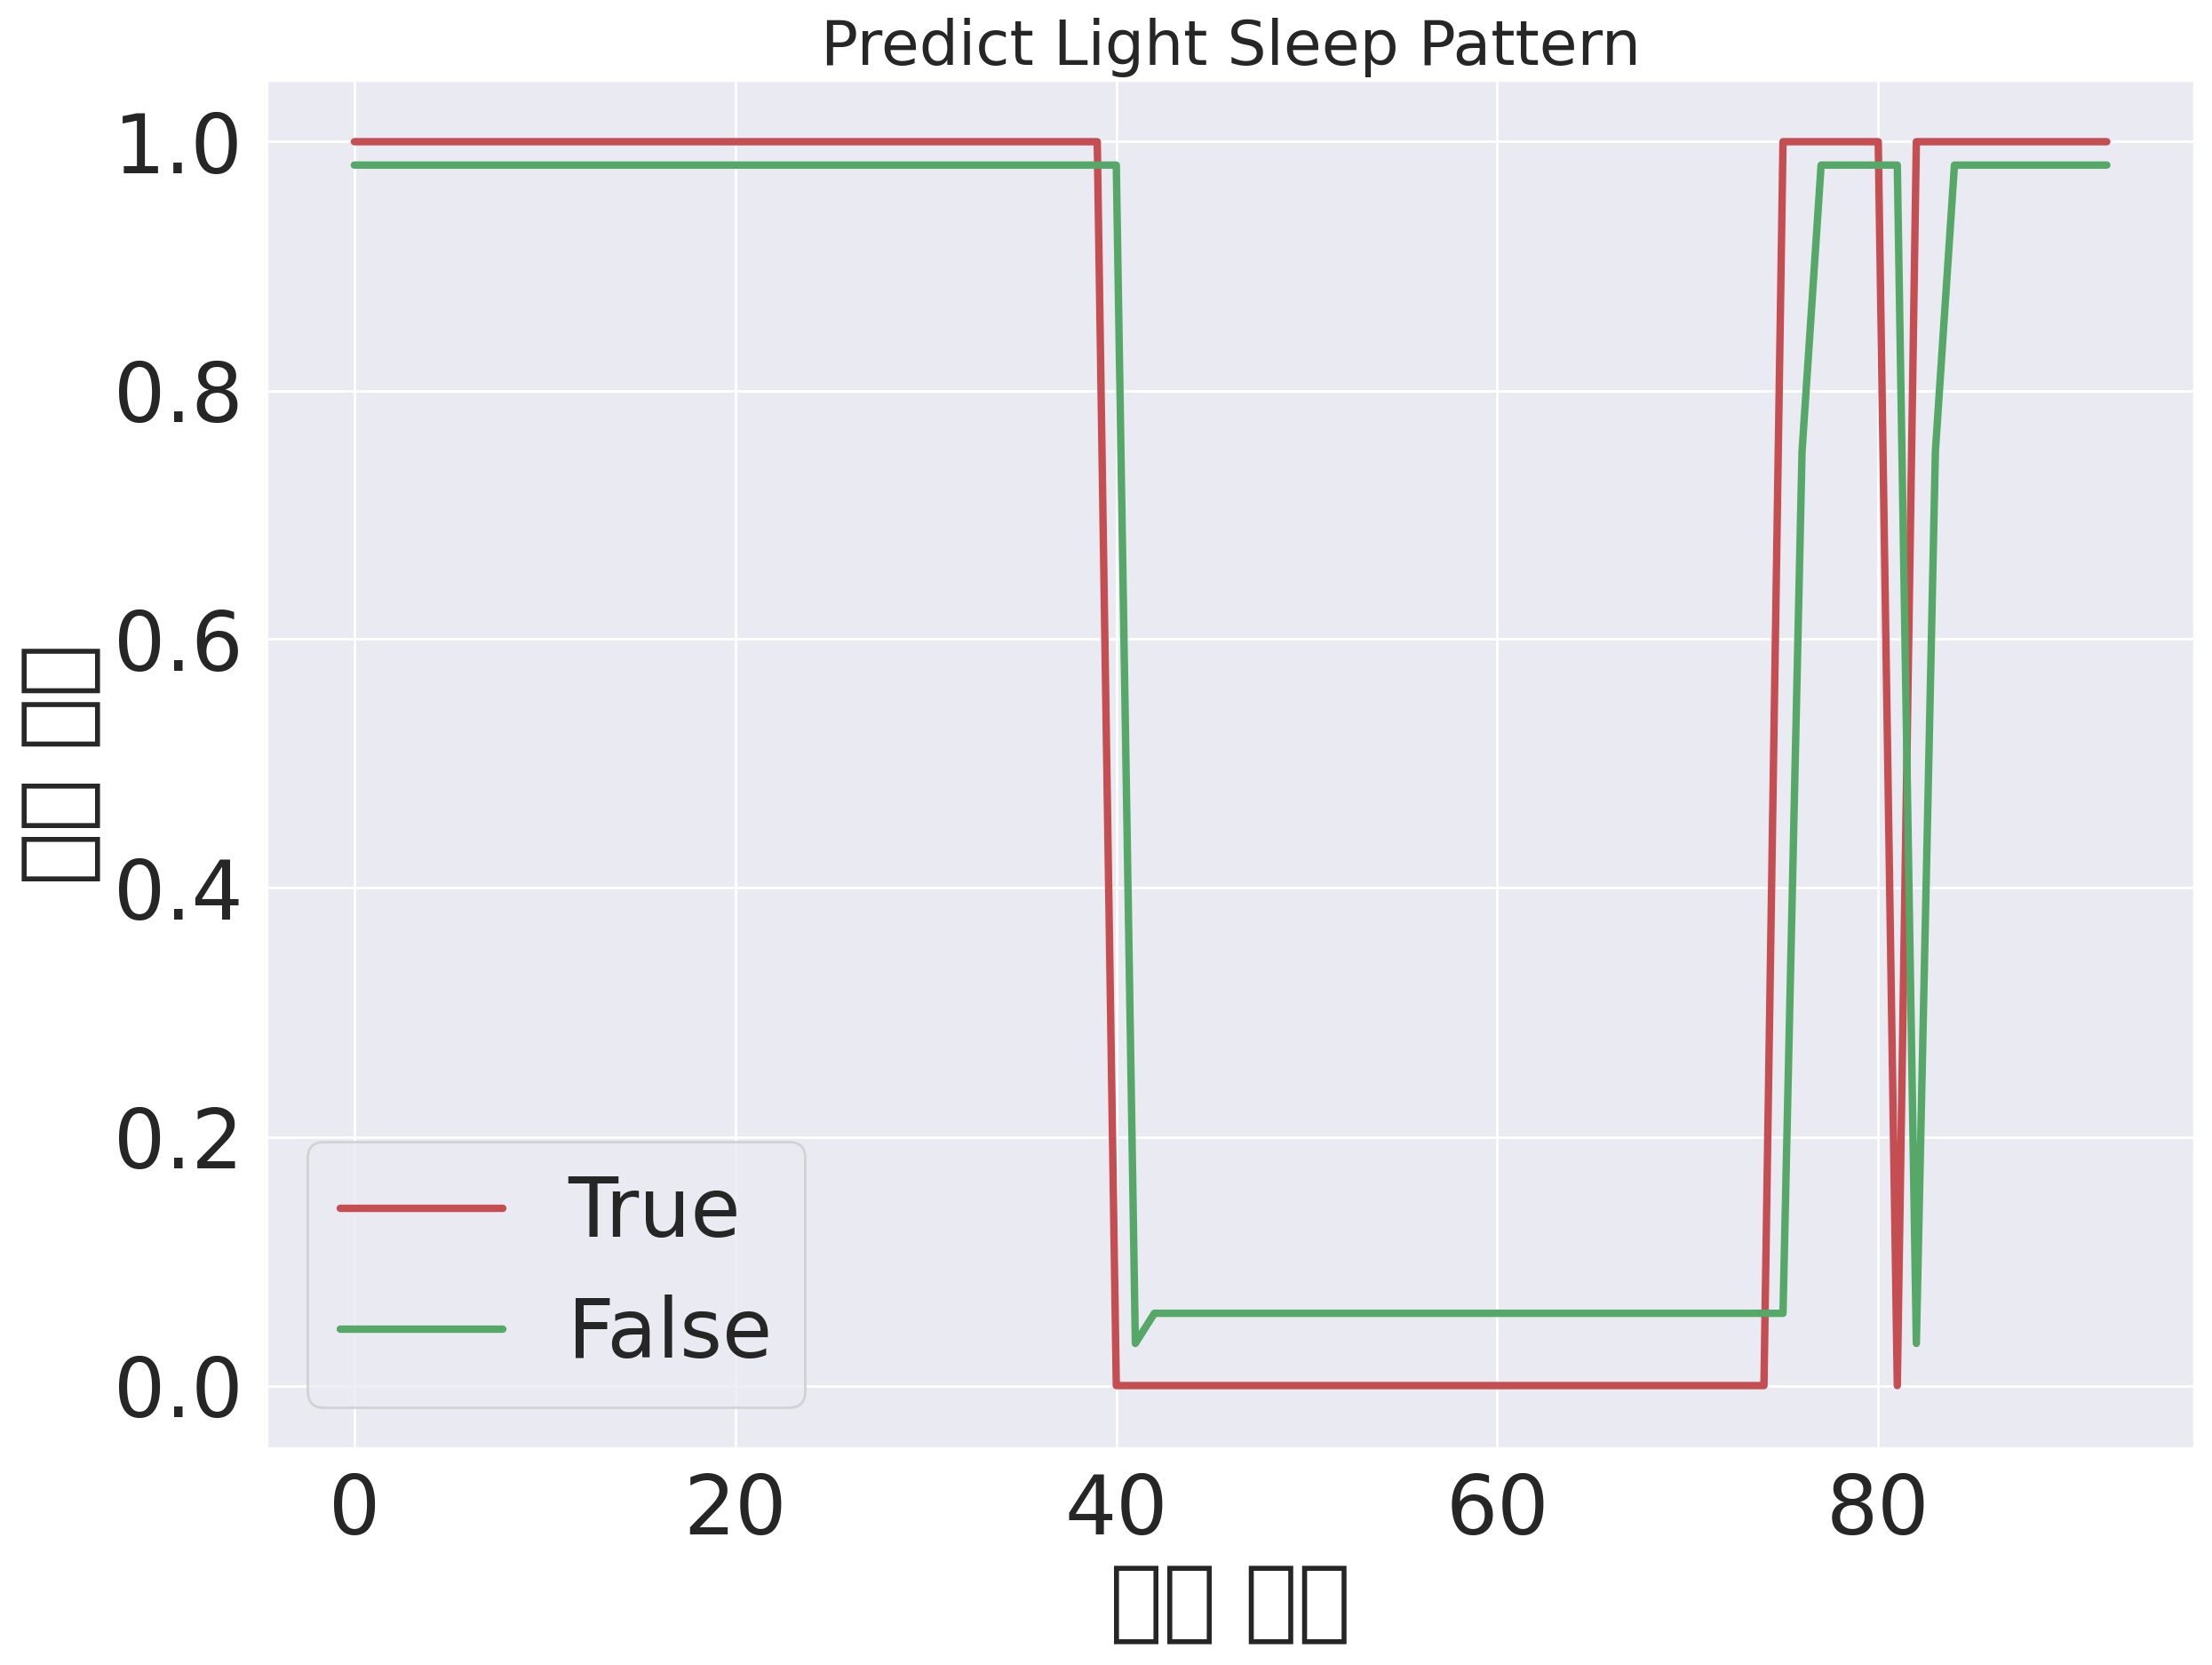

In [ ]:
plt.plot(np.array(y_test), label = 'True', linewidth=3, color='r')
plt.plot(np.array(preds), label = 'False', linewidth=3, color='g')
plt.xlabel('수면 시간')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중간
plt.ylabel('수면 단계')
plt.title('Predict Light Sleep Pattern', fontsize=25)
plt.legend()

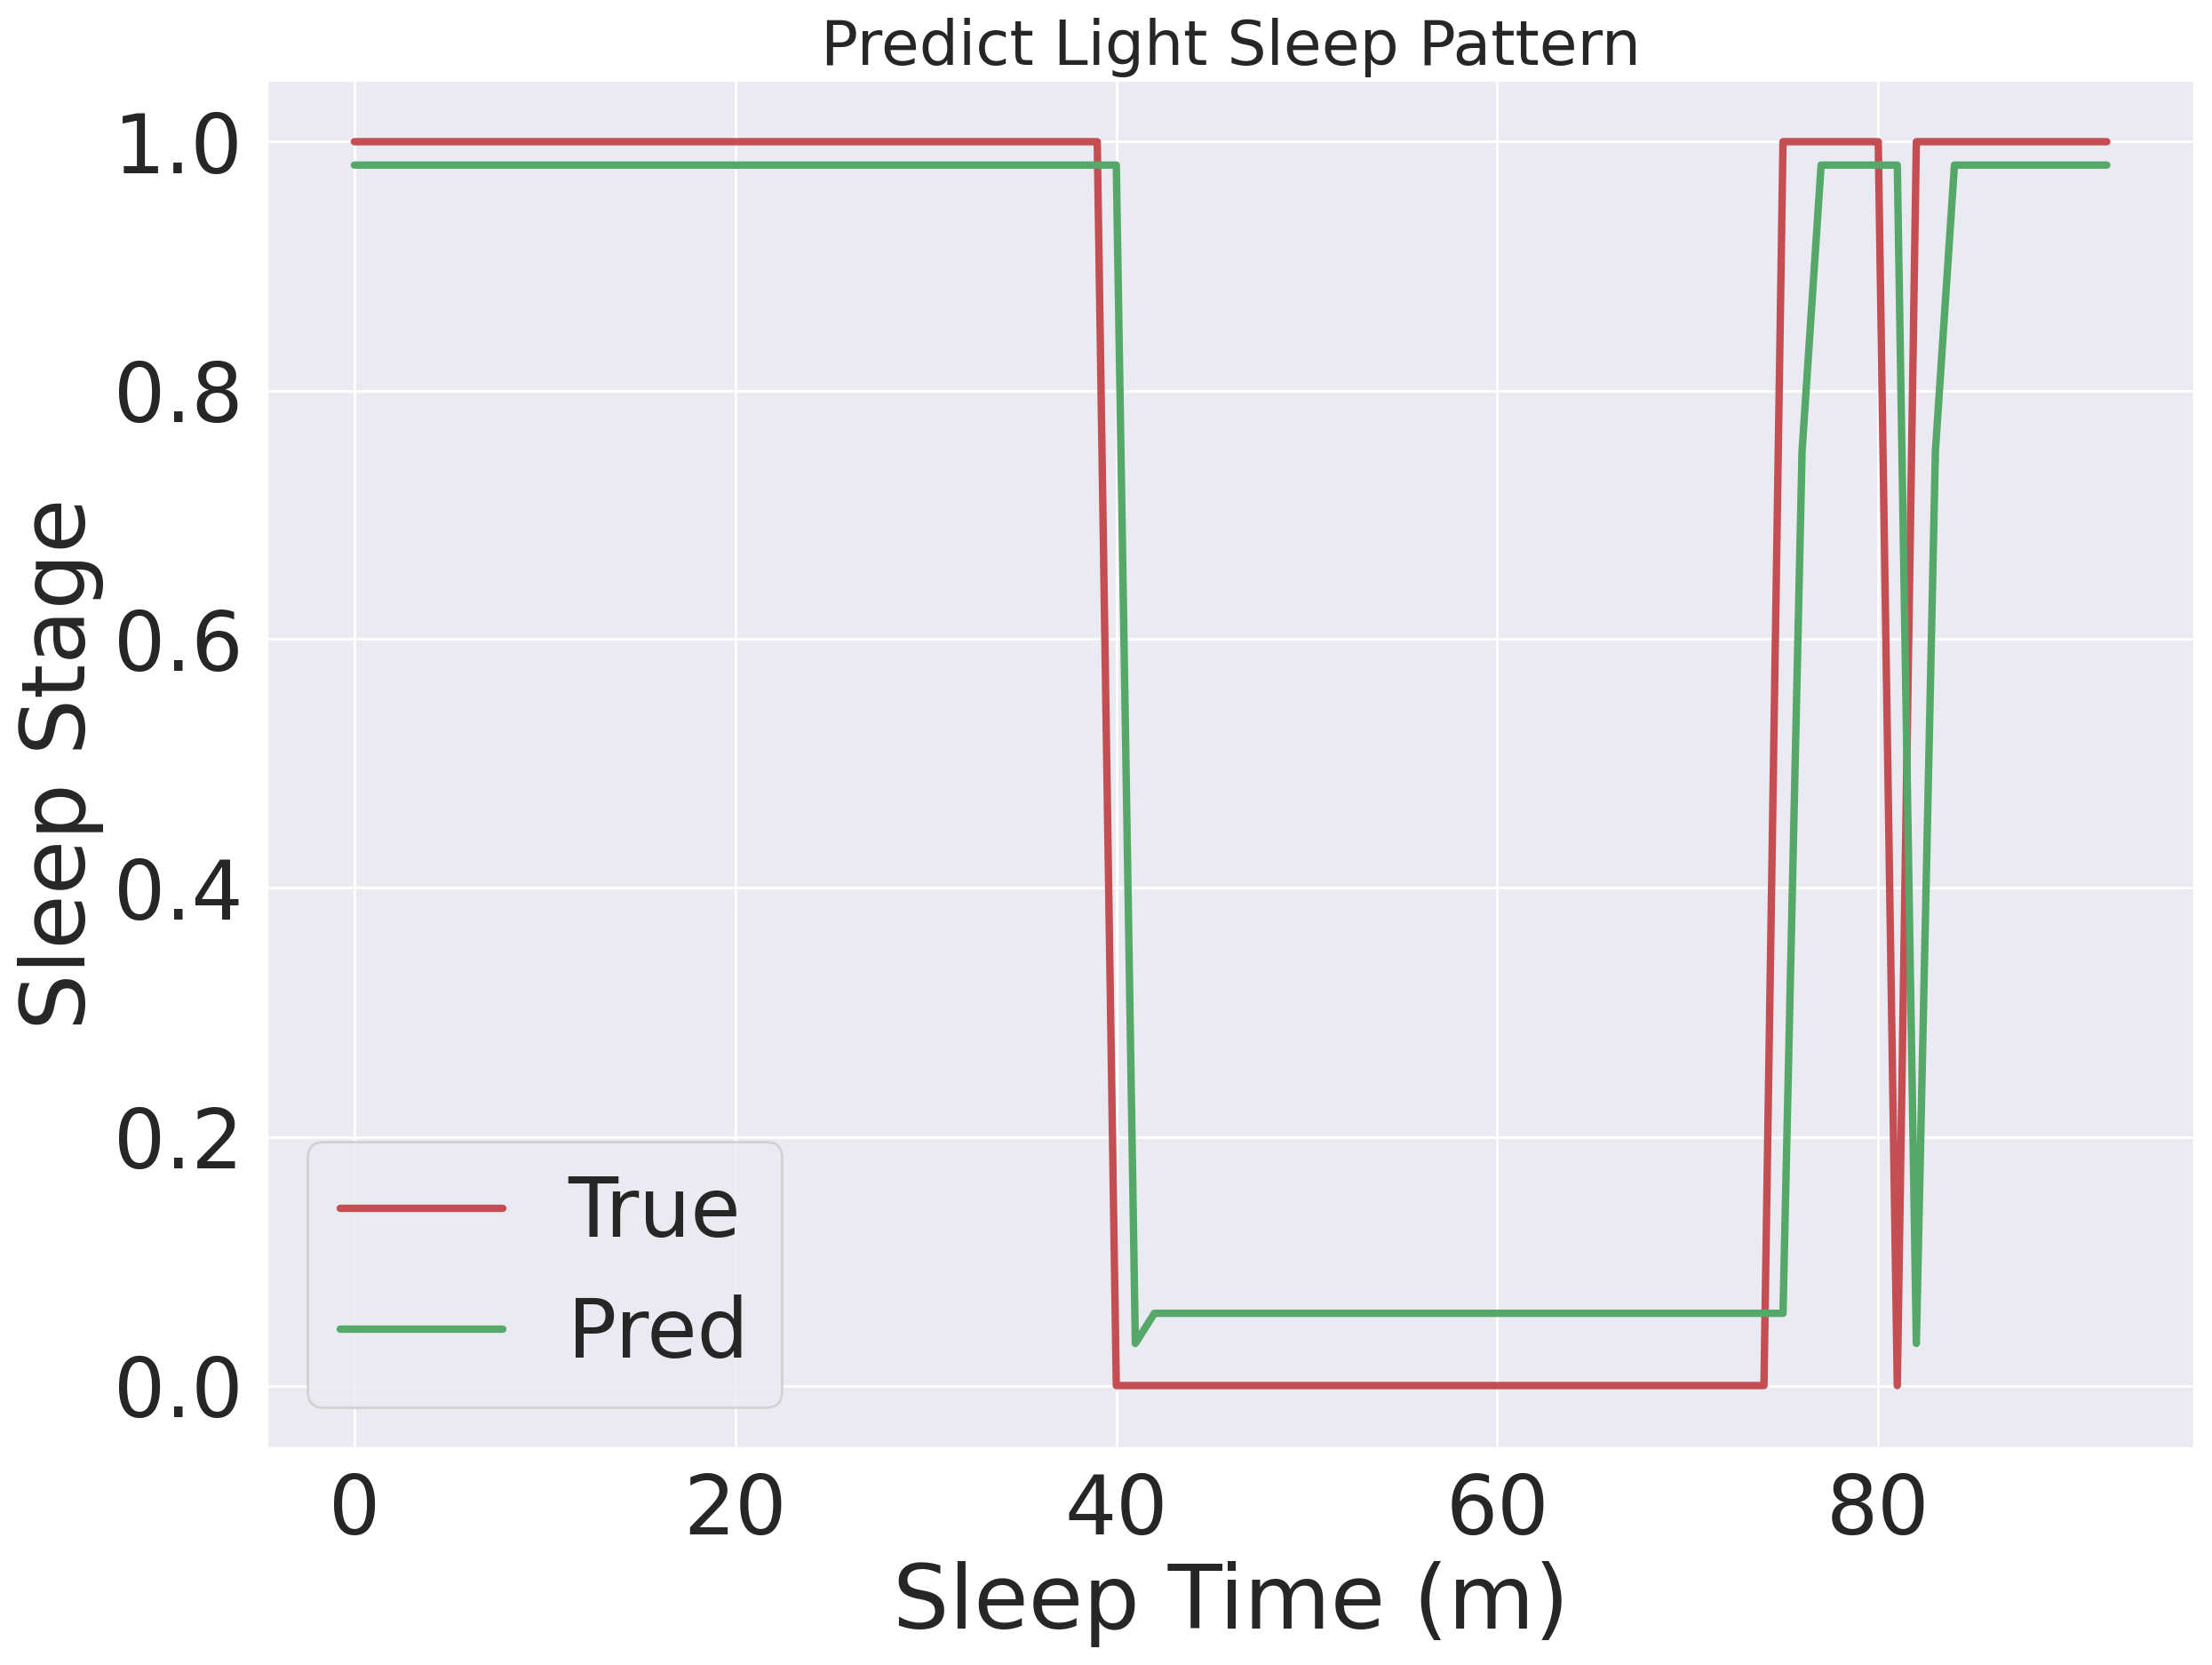

In [ ]:
plt.plot(np.array(y_test), label = 'True', linewidth=3, color='r')
plt.plot(np.array(preds), label = 'Pred', linewidth=3, color='g')
plt.xlabel('Sleep Time (m)')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중간
plt.ylabel('Sleep Stage')
plt.title('Predict Light Sleep Pattern', fontsize=25)
plt.legend()

In [ ]:
plt.plot(np.array(y_test), label = 'True', linewidth=3, color='r')
plt.plot(np.array(preds), label = 'Pred', linewidth=3, color='g')
plt.xlabel('Sleep Time (m)')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중간
plt.ylabel('Sleep Stage')
plt.title('Predict Light Sleep Pattern', fontsize=25)
plt.legend()




x = np.linspace(0, 80, 20)
y1 = np.array(y_test)
y2 = np.array(preds)

fig, ax = plt.subplots()

ax.plot(x, y1, c = 'r',label = 'x^2')
ax.plot(x, y2, c = 'g',label = 'x^3')

leg = plt.legend()

ax.get_legend().remove()

plt.show()

ax.get_legend().remove()

- 예측 변수

In [ ]:
y_pred = make_Tensor(np.array(preds))
y_pred.shape
y_pred = y_pred.reshape(-1,1)
y_pred.shape

torch.Size([93, 1])

In [ ]:
y_test

# 평가 지표

- y_pred를 0 과 1로 변환. thred = 0.5

In [ ]:
real_list = y_test[:,0].tolist()
pred_list = y_pred[:,0].tolist()
print(len(real_list), len(pred_list))

93 93


In [ ]:
pred_list

In [ ]:
pred = []
for i in pred_list:
  if i >= 0.5:
    pred.append(1)
  else:
    pred.append(0)

In [ ]:
pred

In [ ]:
real = y_test[:,0].tolist()

- confusion matrix
- f1-score
- auc

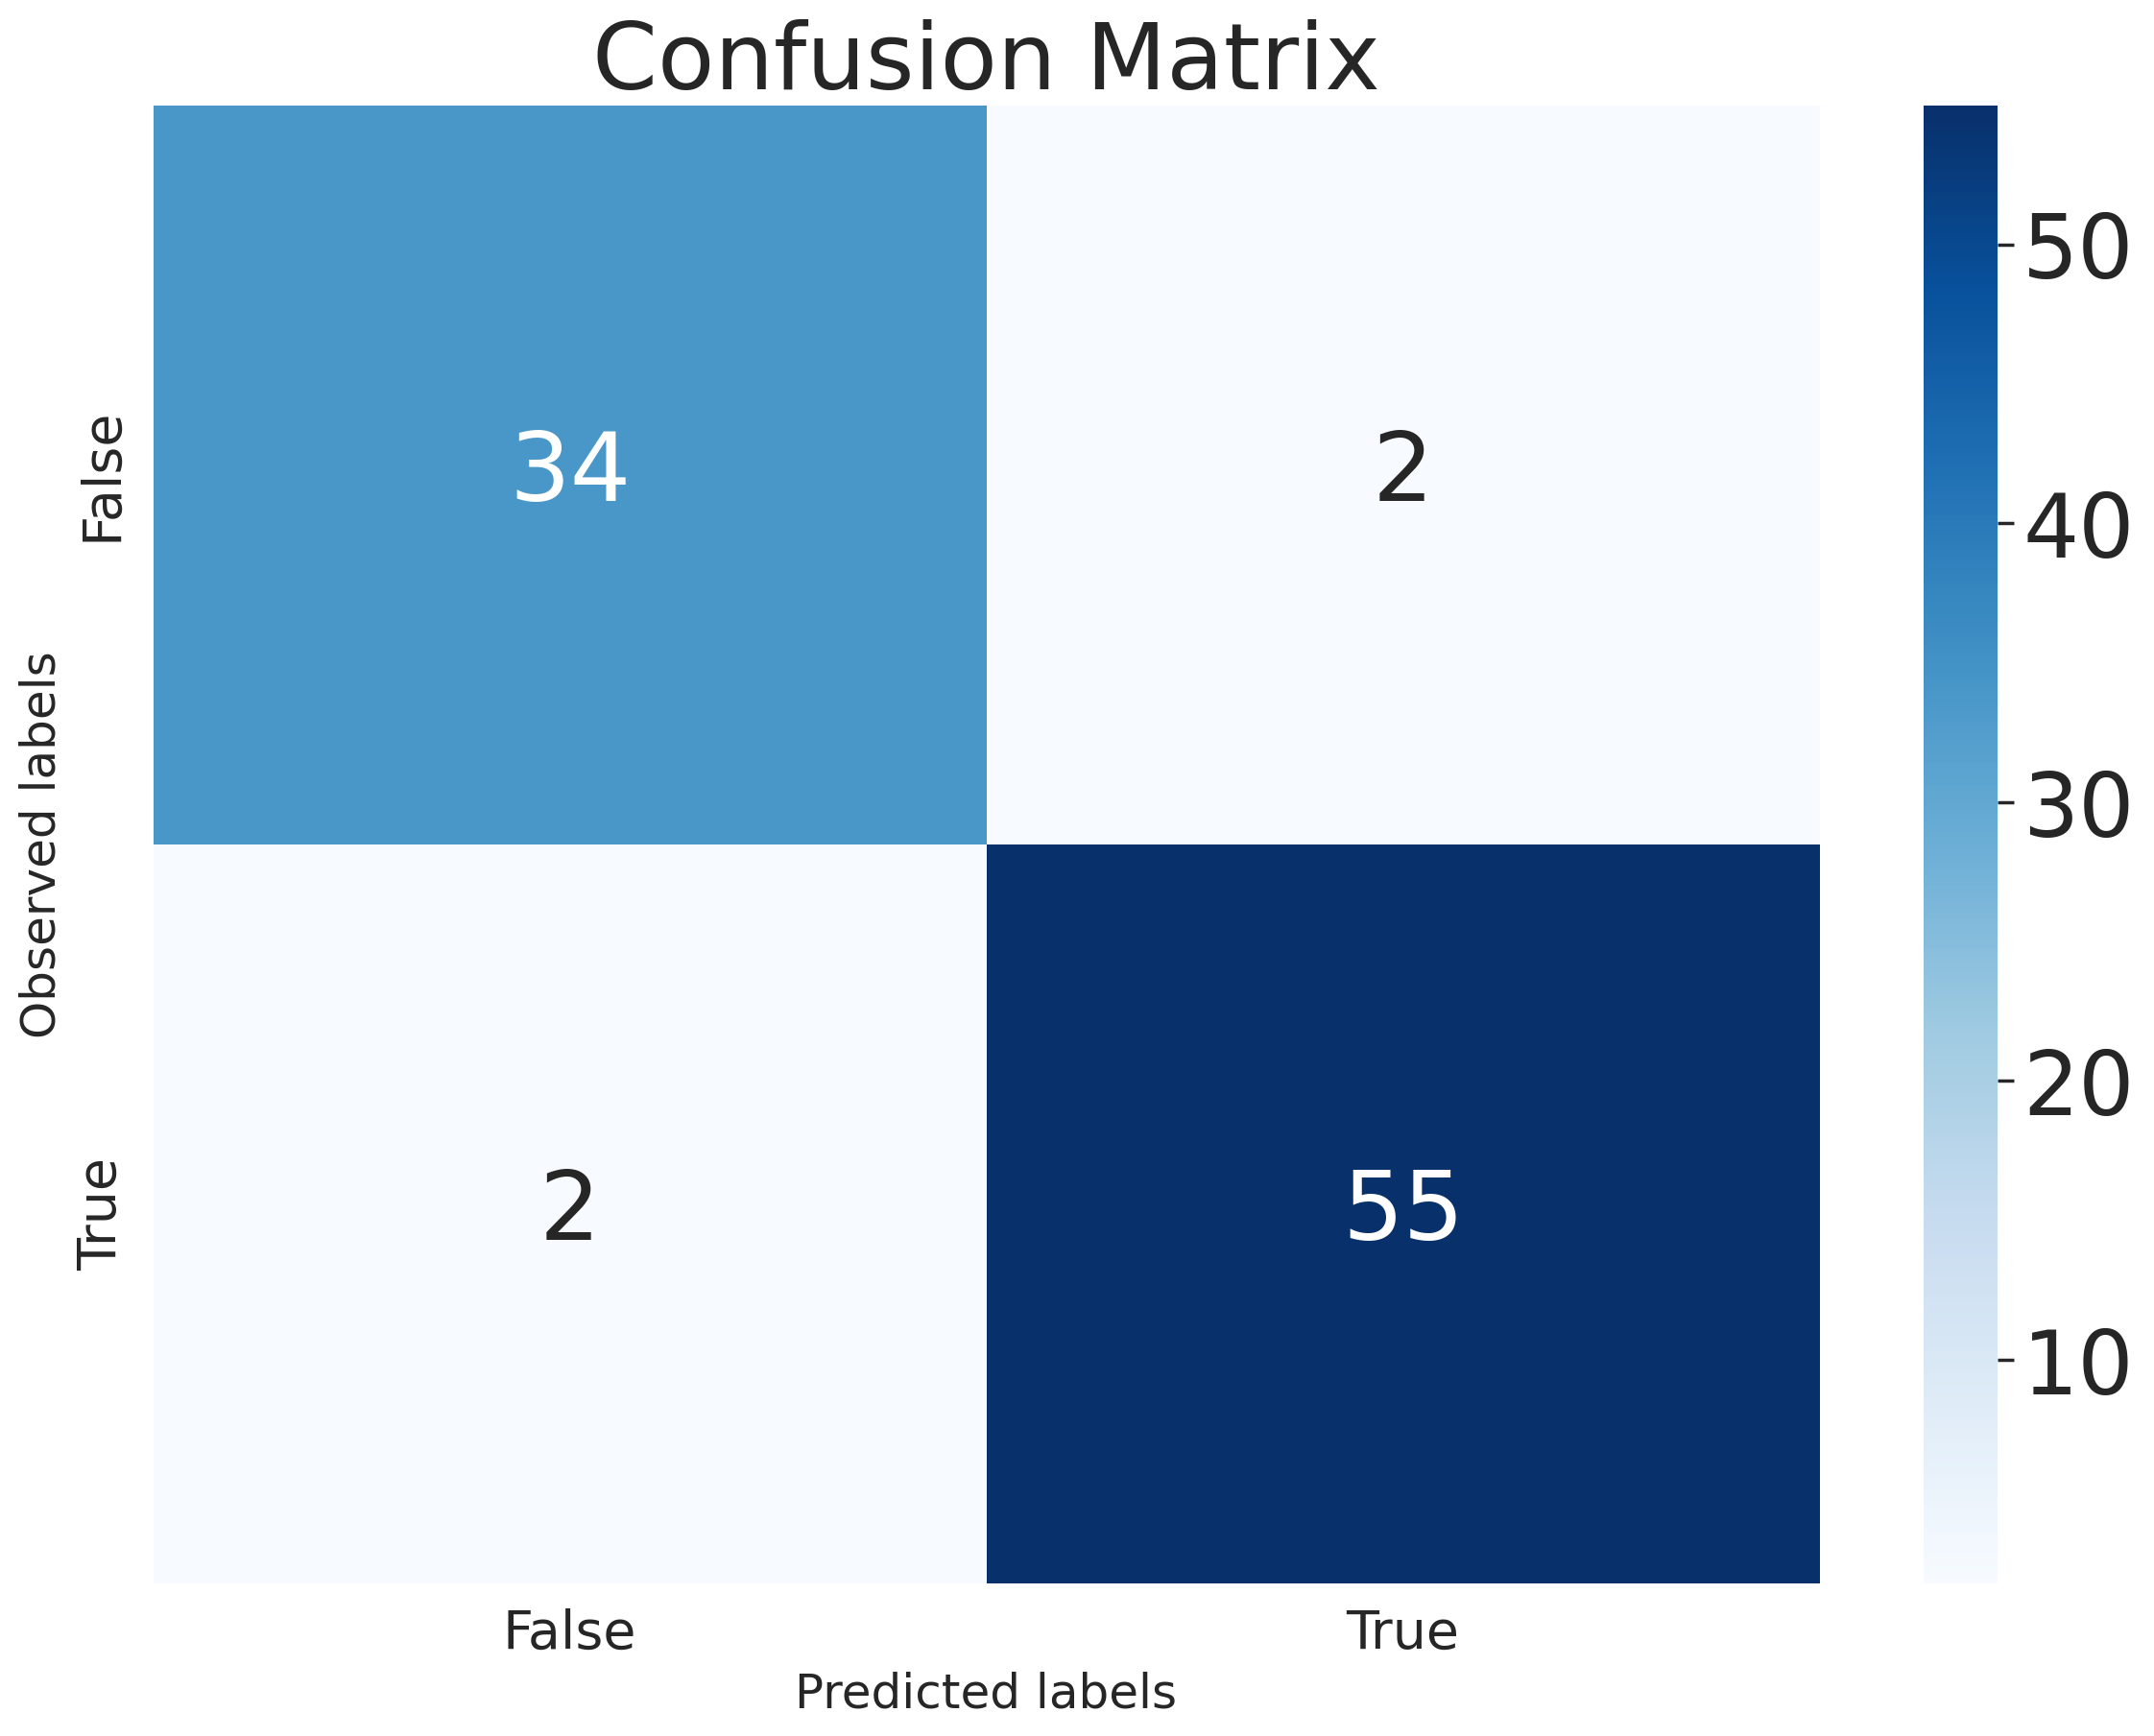

In [ ]:
#sklearn.metrics 모듈을 여러 가지 평가지표에 관한 기능을 제공함.

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#혼동행렬을 만듬
cm = confusion_matrix(real, pred)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'35'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
plt.show()

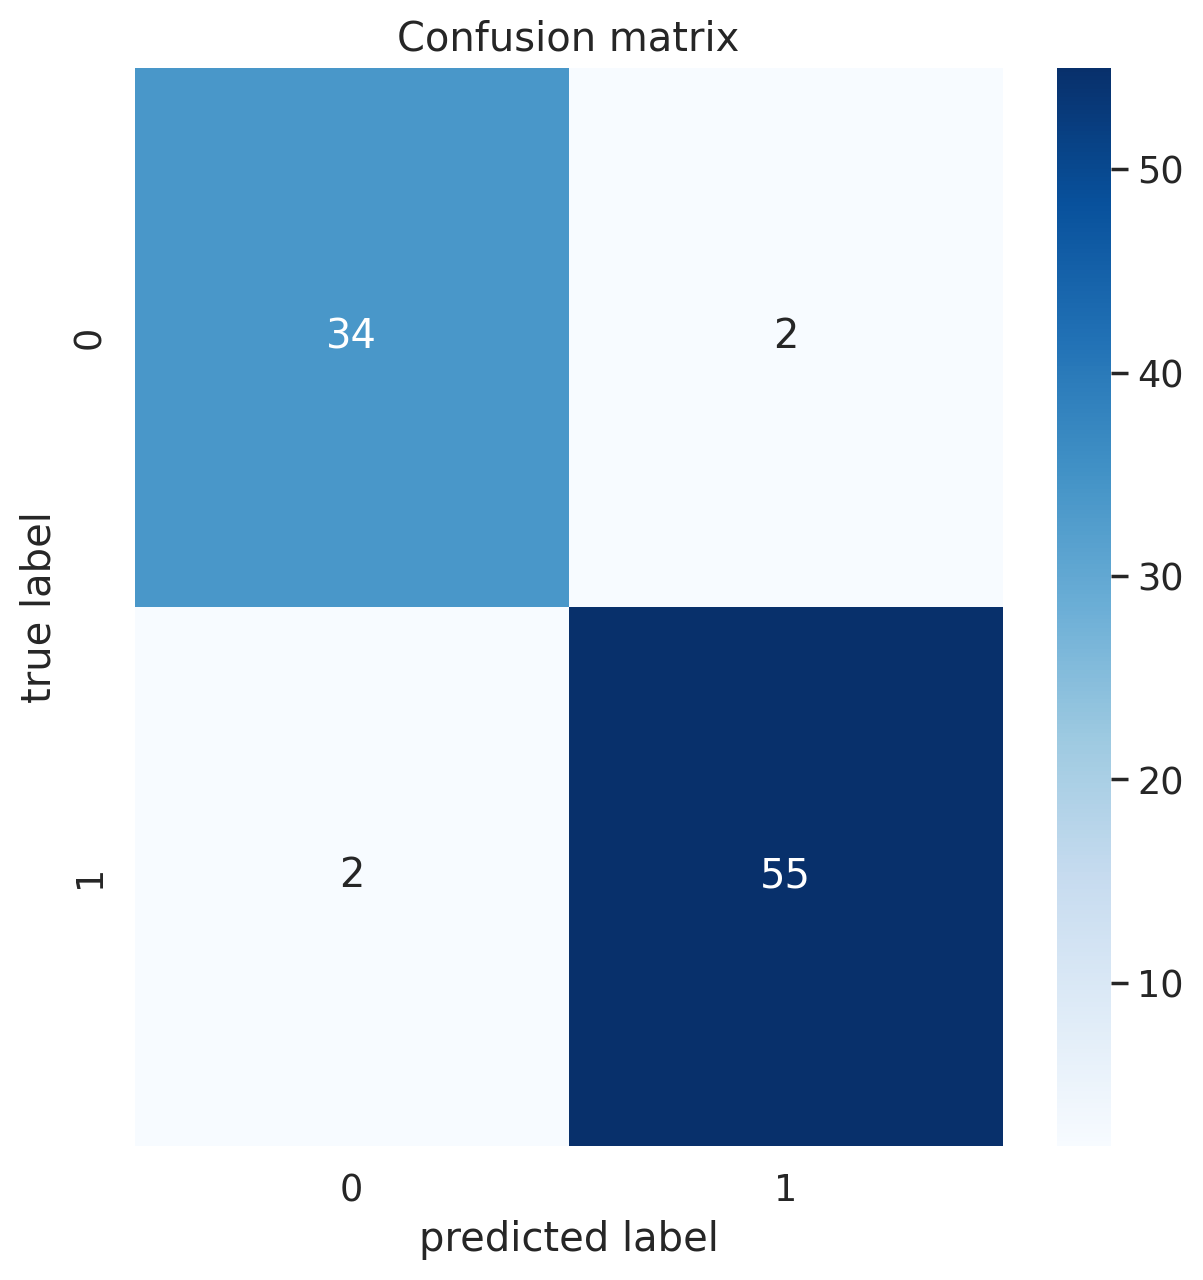


               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        36
         1.0       0.96      0.96      0.96        57

    accuracy                           0.96        93
   macro avg       0.95      0.95      0.95        93
weighted avg       0.96      0.96      0.96        93



In [ ]:
#sklearn.metrics 모듈을 여러 가지 평가지표에 관한 기능을 제공함.

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#혼동행렬을 만듬
plt.figure(figsize = (7,7))
cm = confusion_matrix(real, pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion matrix')
plt.show()
#분류 보고서
print('\n', classification_report(real, pred))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(real, pred)

0.956989247311828

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(real, pred, pos_label=1)
print(fpr, tpr, thresholds)

from sklearn.metrics import auc
auc(fpr, tpr)

[0.         0.05555556 1.        ] [0.         0.96491228 1.        ] [2 1 0]


0.9546783625730993

In [ ]:
# 위 값들은 실제로 1이 많아 그냥 모두 1이라고 예측할 경우 정확도가 높아지고 precision이 높아지는 경우가 있어 그나마 조금더 수치를 조정하여 만든것이 F Score
# f1 score
# (1+b^n) * (precision*recall) / (precision + recall)
# 가중치가 1인 경우를 F1 Score 라고 함
# 정밀도와 재현율의 가중 조화평균
from sklearn.metrics import f1_score
print(f1_score(real, pred, pos_label=1))

0.9649122807017544


In [ ]:
# from sklearn.metrics import precision_score
# precision_score(y_true, y_pred, pos_label=1)

In [ ]:
# # recall (재현율) or sensitivity(민감도) or TPR(True Positive Rate)
# # 실제 양성중에 양성으로 예측된 비율
# # TP / (TP + FN)
# from sklearn.metrics import recall_score
# # pos_label에 기준을 적어줌 1 or 'yes'
# recall_score(y_true, y_pred, pos_label=1)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = real
y_pred = pred
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1],'k-')
plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

TypeError: ignored

# Kaggle dataset for predict

In [ ]:
kg_df = pd.read_csv('/content/drive/MyDrive/KDT_project/CNN-LSTM/sleep.csv').drop(['Unnamed: 0'],axis=1)
kg_df

,Start,End,Category,Duration
0,2022-09-13 01:47:49,2022-09-13 01:59:19,1,11.5
1,2022-09-13 01:59:19,2022-09-13 02:04:49,0,5.5
2,2022-09-13 02:04:49,2022-09-13 02:12:49,1,8.0
3,2022-09-13 02:12:49,2022-09-13 02:27:19,0,14.5
4,2022-09-13 02:27:19,2022-09-13 02:35:49,1,8.5
...,...,...,...,...
8329,2023-05-14 07:20:36,2023-05-14 07:42:06,0,21.5
8330,2023-05-14 07:42:06,2023-05-14 07:43:06,0,1.0
8331,2023-05-14 07:43:06,2023-05-14 07:45:36,1,2.5
8332,2023-05-14 07:45:36,2023-05-14 07:52:06,0,6.5


In [ ]:
kg_df['Start'] = pd.to_datetime(kg_df['Start'], format='%Y-%m-%d %H:%M:%S', errors='raise')
kg_df['End'] = pd.to_datetime(kg_df['End'], format='%Y-%m-%d %H:%M:%S', errors='raise')
kg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Start     8334 non-null   datetime64[ns]
 1   End       8334 non-null   datetime64[ns]
 2   Category  8334 non-null   int64         
 3   Duration  8334 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 260.6 KB


In [ ]:
kg_df['times'] = kg_df['Duration']//0.5
kg_df['times'] = kg_df['times'].astype(int)
kg_df

,Start,End,Category,Duration,times
0,2022-09-13 01:47:49,2022-09-13 01:59:19,1,11.5,23
1,2022-09-13 01:59:19,2022-09-13 02:04:49,0,5.5,11
2,2022-09-13 02:04:49,2022-09-13 02:12:49,1,8.0,16
3,2022-09-13 02:12:49,2022-09-13 02:27:19,0,14.5,29
4,2022-09-13 02:27:19,2022-09-13 02:35:49,1,8.5,17
...,...,...,...,...,...
8329,2023-05-14 07:20:36,2023-05-14 07:42:06,0,21.5,43
8330,2023-05-14 07:42:06,2023-05-14 07:43:06,0,1.0,2
8331,2023-05-14 07:43:06,2023-05-14 07:45:36,1,2.5,5
8332,2023-05-14 07:45:36,2023-05-14 07:52:06,0,6.5,13


# predict를 위해 사용할 5/4일 데이터만 우선 가져오고자 함.

In [ ]:
import datetime

dateformat = '%Y-%m-%d %H:%M:%S'
start_datetime = '2023-05-03 12:00:00'
end_datetime = '2023-05-04 12:00:00'

start_datetime = datetime.datetime.strptime(start_datetime, dateformat)
end_datetime = datetime.datetime.strptime(end_datetime, dateformat)

pred_df = kg_df[(kg_df['Start']>=start_datetime) & (kg_df['End']<=end_datetime)]
pred_df

,Start,End,Category,Duration,times
7986,2023-05-04 01:07:32,2023-05-04 01:17:02,1,9.5,19
7987,2023-05-04 01:17:02,2023-05-04 01:18:02,0,1.0,2
7988,2023-05-04 01:18:02,2023-05-04 01:31:02,1,13.0,26
7989,2023-05-04 01:31:02,2023-05-04 01:37:32,0,6.5,13
7990,2023-05-04 01:37:32,2023-05-04 01:43:02,1,5.5,11
7991,2023-05-04 01:43:02,2023-05-04 02:11:02,0,28.0,56
7992,2023-05-04 02:11:02,2023-05-04 02:22:02,1,11.0,22
7993,2023-05-04 02:22:02,2023-05-04 02:45:02,0,23.0,46
7994,2023-05-04 02:45:02,2023-05-04 03:14:02,1,29.0,58
7995,2023-05-04 03:14:02,2023-05-04 03:18:02,0,4.0,8


In [ ]:
kg_dt = pred_df.loc[:,['times','Category']]
kg_dt

,times,Category
7986,19,1
7987,2,0
7988,26,1
7989,13,0
7990,11,1
7991,56,0
7992,22,1
7993,46,0
7994,58,1
7995,8,0


In [ ]:
# 00시 00분 30초 ~ 07시 44분 00초 까지
time_hour = []
for i in range(8):
  time_hour.append('0' + str(i))
time_hour

# 00시 00분 00초 ~ 07시 44분 00초 까지
time_minute = []
for i in range(10):
  time_minute.append('0' + str(i))
for i in range(10,60):
  time_minute.append( str(i))
len(time_minute)

time = []
for i in time_hour:
  for j in time_minute:
    time.append(i + j)

time = time[:-15]
print(time[0], time[-1])

time_list = []
for i in time:
  time_list.append(i + '00')
  time_list.append(i + '30')

time_list = time_list[1:-1]
len(time_list)

print(time_list[0], time_list[-1])

0000 0744
000030 074400


In [ ]:
DateTime = []

for i in time_list:
  DateTime.append('20230504' + i)

DateTime

In [ ]:
kg_data = np.array(kg_dt)

x_list = []
for x in kg_data:
  if x[1] != 0:
    timeseries = np.ones([int(x[0])])
    x_list.append(timeseries)
  else:
    timeseries = np.zeros([int(x[0])])
    x_list.append(timeseries)

ts = np.concatenate(x_list)
print(ts.shape)

(838,)


In [ ]:
928 - 838
# 길이가 안맞아서 맞춰줘야 함.

90

In [ ]:
z_cnt = 0
o_cnt = 0
for i in ts:
  if i == 0:
    z_cnt += 1
  else:
    o_cnt += 1

print(z_cnt, o_cnt)

280 558


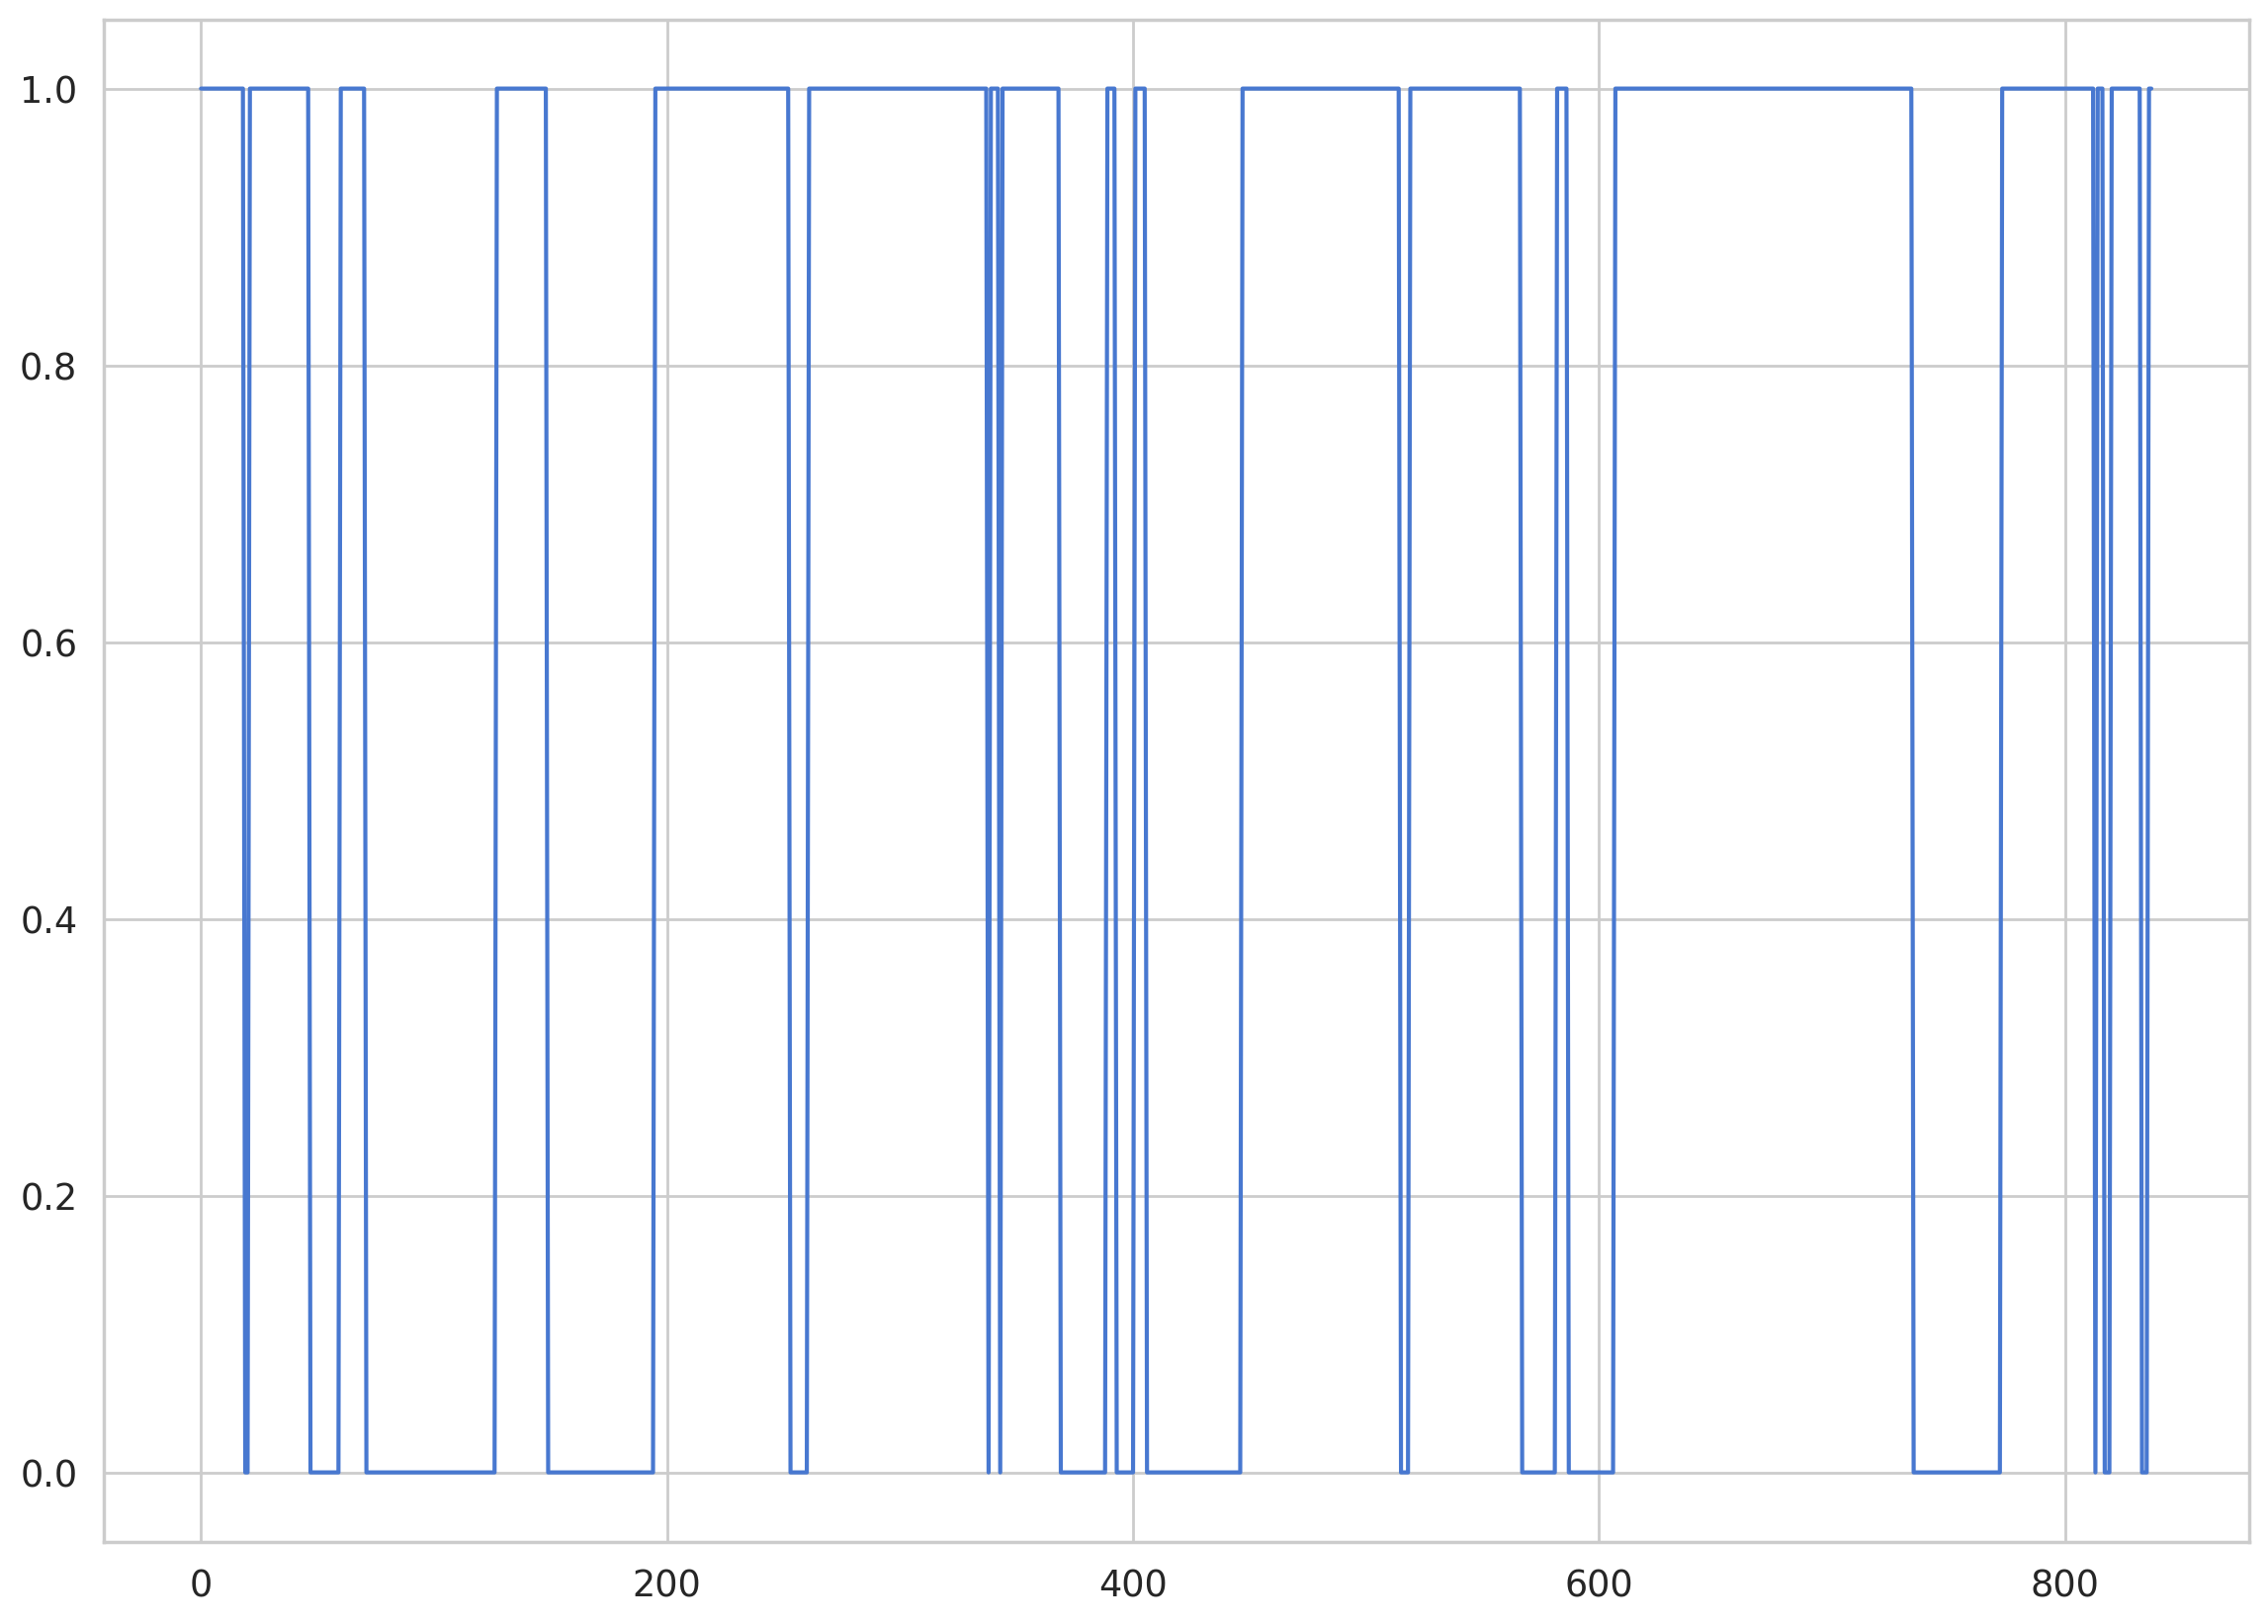

In [ ]:
plt.plot(ts)

In [ ]:
aug = np.append(ts[:90], ts)
len(aug)

928

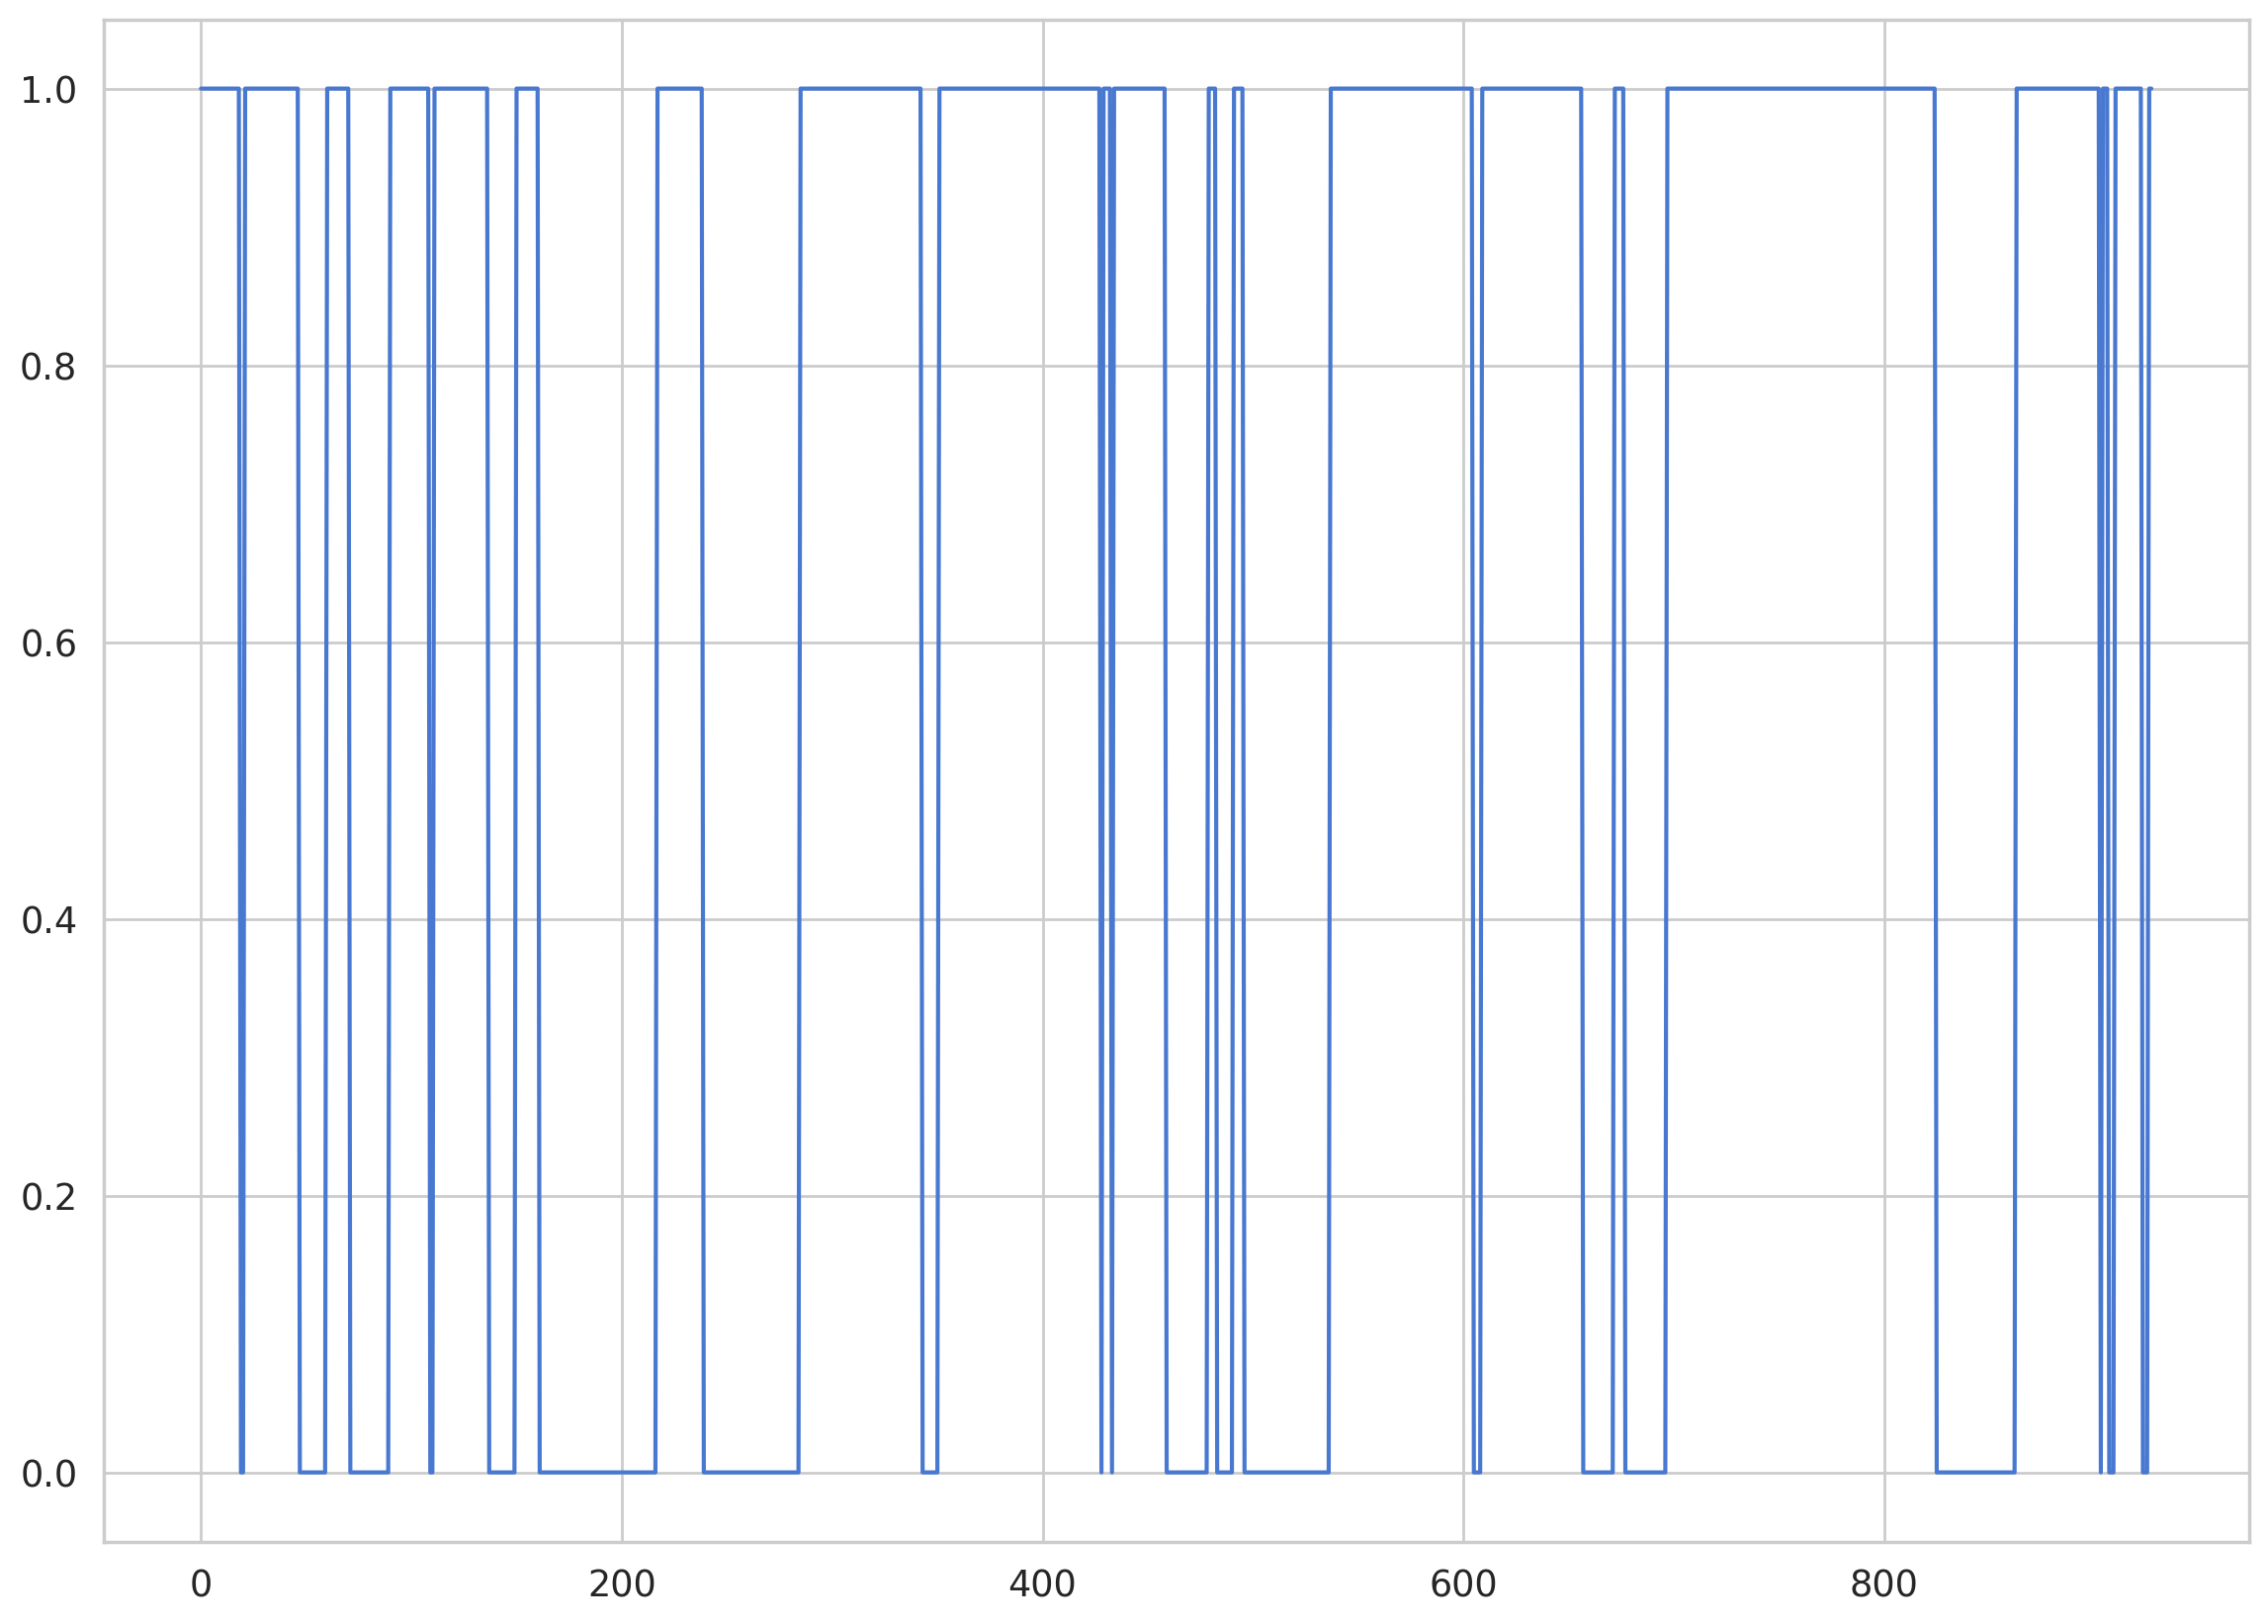

In [ ]:
plt.plot(aug)

In [ ]:
kg_y_pred = pd.DataFrame([])
kg_y_pred['ds'] = DateTime
kg_y_pred['y'] = aug.astype(int)
kg_y_pred

,ds,y
0,20230504000030,1
1,20230504000100,1
2,20230504000130,1
3,20230504000200,1
4,20230504000230,1
...,...,...
923,20230504074200,0
924,20230504074230,0
925,20230504074300,0
926,20230504074330,1


In [ ]:
928//20

46

In [ ]:
import numpy as np

def create_sequences(data, seq_length):

  xs = []
  ys = []
  for j in range(928 // seq_length):
    x = data.iloc[j*seq_length:((j+1)*seq_length)]
    y = data.iloc[(j+1)+seq_length]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

seq_length = 20  # 10분마다 다음 수면 단계를 예측. 10분 -> seq_length = 10 * 2
X_test, y_test = create_sequences(data, seq_length)

In [ ]:
print(X_test.shape, y_test.shape)

(46, 20, 1) (46, 1)


In [ ]:
import torch

def make_Tensor(array):
    return torch.from_numpy(array).float()

In [ ]:
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

## 예측

In [ ]:
pred_dataset = X_test

with torch.no_grad():
  preds = []
  for _ in range(len(pred_dataset)):
    model.reset_hidden_state()
    y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)

RuntimeError: ignored

In [ ]:
plt.plot(np.array(y_test), label = 'True')
plt.plot(np.array(preds), label = 'Pred')
plt.xlabel('Sleep Time (m)')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중
plt.ylabel('Sleep Stage (1:Core, 0:Not-Core)')
plt.title('Predict Light Sleep Pattern')
plt.legend()

In [ ]:
import numpy as np

def create_sequences(data, seq_length):
  xs = []
  ys = []
  for j in range(len(data)-seq_length):
    x = data.iloc[j:(j+seq_length)]
    y = data.iloc[j+seq_length]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

seq_length = 5
X_test, y_test = create_sequences(data, seq_length)

In [ ]:
X.shape, y.shape

((923, 5, 1), (923, 1))

In [ ]:
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [ ]:
pred_dataset = X_test

with torch.no_grad():
  preds = []
  for _ in range(len(pred_dataset)):
    model.reset_hidden_state()
    y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)

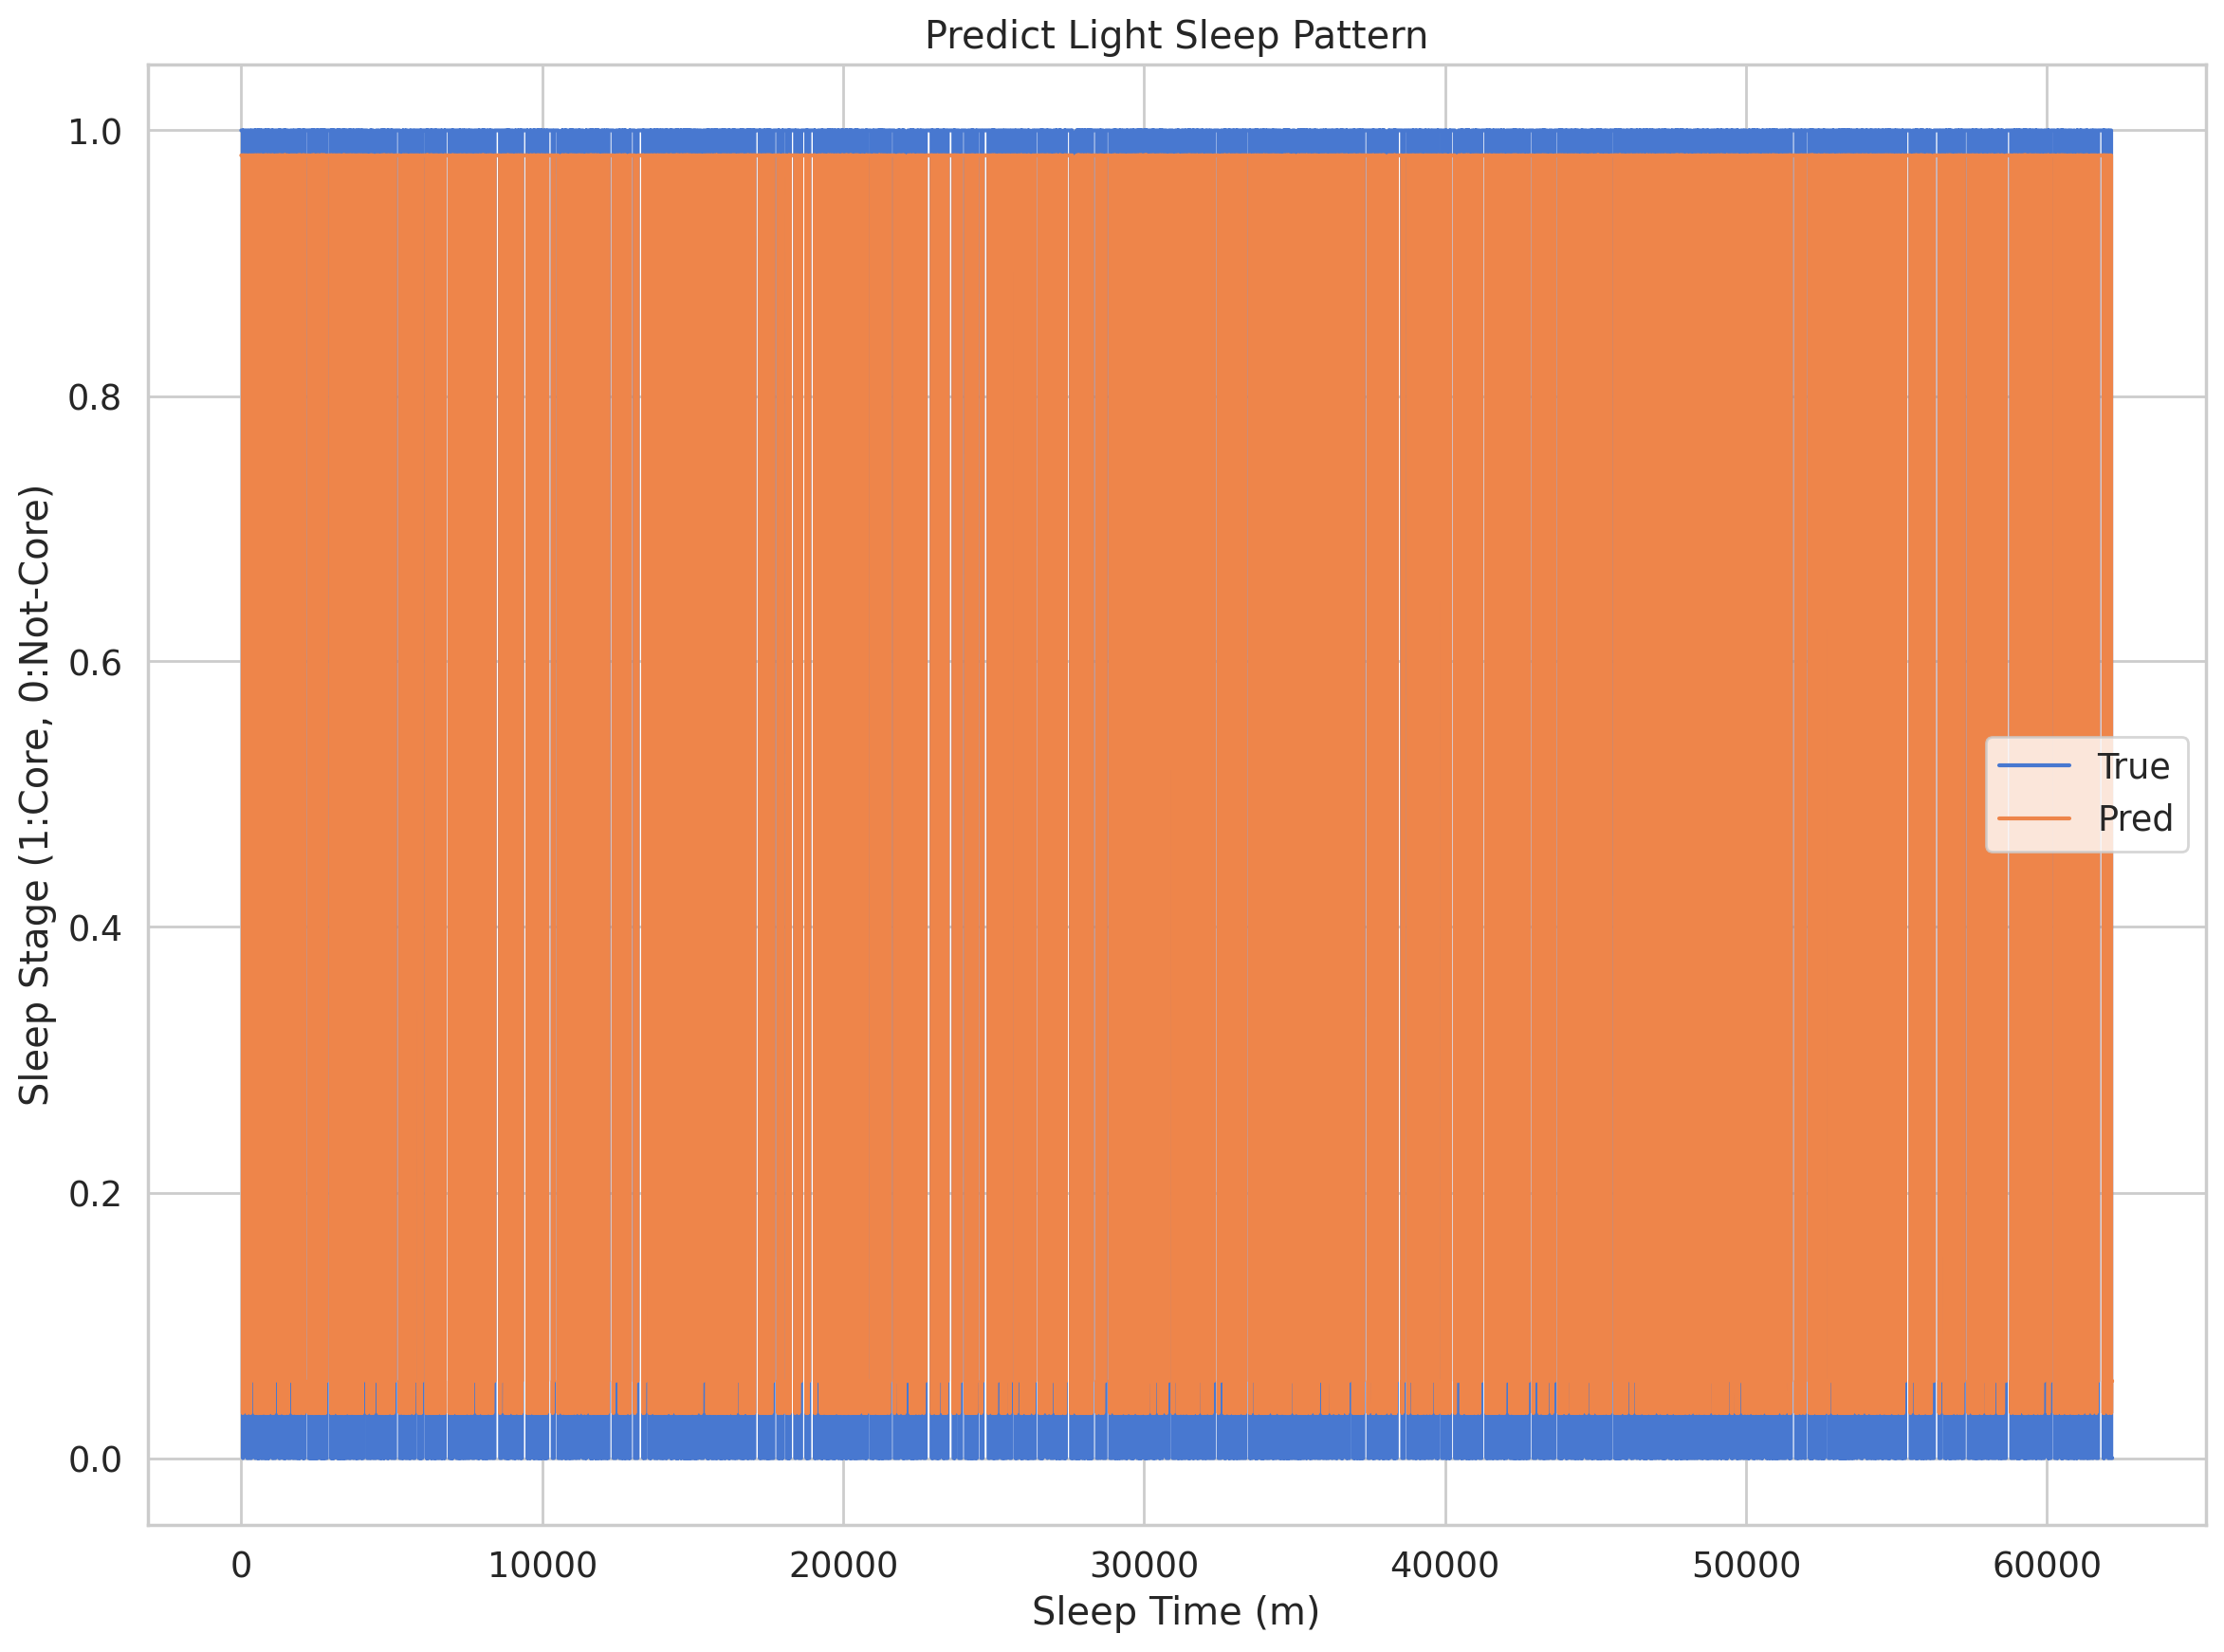

In [ ]:
plt.plot(np.array(y_test), label = 'True')
plt.plot(np.array(preds), label = 'Pred')
plt.xlabel('Sleep Time (m)')  # 엄밀히 따지면 30초마다의 수면 기록이긴 하지만 연속된 수면 기록이 아니고 중간중
plt.ylabel('Sleep Stage (1:Core, 0:Not-Core)')
plt.title('Predict Light Sleep Pattern')
plt.legend()